
## Exploration (EDA) für `spotify.sqlite`

**Ziel:** Diese Notebook führt eine EDA für den bereitgestellten Spotify-Basisdatensatz (SQLite) durch.

In [13]:

# --- Grundlegendes Setup ---
import sqlite3
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Matplotlib: keine Styles/keine festen Farben setzen
plt.rcParams.update({'figure.figsize': (8, 5), 'axes.grid': True})

RAW_SPOTIFY_DB_PATH = Path("../data/raw/spotify.sqlite")
SCHEMA_REPORTS_DIR = Path("../data/reports/01_schema_overview")
SCHEMA_REPORTS_DIR.mkdir(parents=True, exist_ok=True)


### 1.1 Datenbankstruktur und Tabellenübersicht

Bevor ich mit der eigentlichen Analyse beginne, will ich ein klares Verständnis der Struktur des Spotify-Datenbestands gewinnen.
Dazu prüfe ich:
- Welche Tabellen existieren in der SQLite-Datenbank
- Wie viele Zeilen jede Tabelle enthält
- Welche Spalten und Datentypen sie besitzen
- Welche Felder Primärschlüssel sind


In [14]:
# Verbindung nur für Schema-Abfrage (UTF-8/Bytes egal, da keine Daten gelesen werden)
pd.set_option('display.max_colwidth', None)

con_overview = sqlite3.connect(str(RAW_SPOTIFY_DB_PATH))

# Gibt alle Benutzertabellen (ohne SQLite-Systemtabellen) zurück
def list_user_tables(con):
    q = """
    SELECT name
    FROM sqlite_master
    WHERE type='table' AND name NOT LIKE 'sqlite_%'
    ORDER BY name;
    """
    return pd.read_sql(q, con)['name'].tolist()

# Liest Spalteninformationen einer Tabelle (Name, Typ, Primärschlüssel usw.)
def get_table_info(con, table):
    info = pd.read_sql(f"PRAGMA table_info({table});", con)
    return info

# Gibt die Anzahl der Zeilen einer Tabelle zurück
def get_rowcount(con, table):
    try:
        return pd.read_sql(f"SELECT COUNT(*) AS n FROM {table};", con).iloc[0, 0]
    except Exception:
        return None

# Baut eine Gesamtübersicht: Tabellenname, Zeilenanzahl, Spaltenanzahl, Spaltenliste
def build_db_summary(con, max_preview_chars: int = 140):
    tables = list_user_tables(con)
    rows = []
    column_details = {}

    for t in tables:
        info = get_table_info(con, t)
        column_details[t] = info

        # Spaltenliste mit Typ und PK-Markierung
        col_display = [
            f"{r['name']} ({r['type']})" + (" [PK]" if r['pk'] == 1 else "")
            for _, r in info.iterrows()
        ]
        rowcount = get_rowcount(con, t)

        rows.append({
            "table": t,
            "rowcount": rowcount,
            "n_columns": len(col_display),
            "columns_full": ", ".join(col_display)
        })

    summary = pd.DataFrame(rows).sort_values("rowcount", ascending=False)
    # Kürze Spaltenliste für Übersicht (volle Liste bleibt in columns_full)
    summary["columns_preview"] = summary["columns_full"].apply(
        lambda s: s if len(s) <= max_preview_chars else s[:max_preview_chars] + "…"
    )
    summary = summary[["table", "rowcount", "n_columns", "columns_preview", "columns_full"]]
    return summary, column_details

#  Erstelle die Übersicht und zeige sie an
db_summary, db_column_details = build_db_summary(con_overview)

print("Tabellen-Übersicht:")
display(db_summary[["table", "rowcount", "n_columns", "columns_preview"]])

#  Speichere die vollständige Übersicht als CSV
out_dir = Path(SCHEMA_REPORTS_DIR)
out_dir.mkdir(parents=True, exist_ok=True)
db_summary.to_csv(out_dir / "schema_overview.csv", index=False, encoding="utf-8")
print(f" Gespeichert: {out_dir / 'schema_overview.csv'}")

#  Verbindung schließen
con_overview.close()



Tabellen-Übersicht:


table  rowcount  n_columns  \
7    r_track_artist  11840402          2   
5   r_albums_tracks   9900173          2   
8            tracks   8741672         10   
2    audio_features   8740043         15   
0            albums   4820754          6   
1           artists   1066031          4   
4  r_albums_artists    921486          2   
6    r_artist_genre    487386          2   
3            genres      5489          1   

                                                                                                                                 columns_preview  
7                                                                                                                      track_id (), artist_id ()  
5                                                                                                                       album_id (), track_id ()  
8  id (), disc_number (), duration (), explicit (), audio_feature_id (), name (), preview_url (), track_number (), popularity (), is_playable (…  
2  id (), acousticness (), analysis_url (), danceability (), duration (), energy (), instrumentalness (), key (), liveness (), loudness (), mod…  
0                                                                  id (), name (), album_group (), album_type (), release_date (), popularity ()  
1                                                                                                    name (), id (), popularity (), followers ()  
4                                                                                                                      album_id (), artist_id ()  
6                                                                                                                      genre_id (), artist_id ()  
3                                                                                                                                          id ()

 Gespeichert: ..\data\reports\01_schema_overview\schema_overview.csv


###  1.2 Überblick über Tabelleninhalte

#### Ziel

Nachdem wir das Schema und die Zeilenzahlen kennen, wollen wir uns nun die Inhalte der wichtigsten Tabellen ansehen.
Wir prüfen einige Beispieleinträge und Datentypen, um zu verstehen, welche Informationen für Analysen relevant sind.

#### Vorgehen

Wir laden jeweils die erste Zeile der Tabellen nur zur Überblick.

In [15]:
key_tables = ['artists', 'tracks', 'audio_features', 'albums', 'genres']
con = sqlite3.connect(str(RAW_SPOTIFY_DB_PATH))
for t in key_tables:
    print(f"\n{'='*70}\n Tabelle: {t.upper()}\n{'='*70}")
    try:
        df = pd.read_sql(f"SELECT * FROM {t} LIMIT 5;", con)
        display(df.head(1))  # Beispielzeile
        print("\n Spaltentypen:")
        display(df.dtypes.to_frame(name="dtype"))
    except Exception as e:
        print(f" Fehler beim Lesen von {t}: {e}")


 Tabelle: ARTISTS


name                      id  popularity  followers
0  Xzibit  4tujQJicOnuZRLiBFdp3Ou          69    1193665


 Spaltentypen:


dtype
name        object
id          object
popularity   int64
followers    int64


 Tabelle: TRACKS


id  disc_number  duration  explicit  \
0  1dizvxctg9dHEyaYTFufVi            1    275893         1   

         audio_feature_id                                   name preview_url  \
0  1dizvxctg9dHEyaYTFufVi  Gz And Hustlas (feat. Nancy Fletcher)               

   track_number  popularity  is_playable  
0            12           0          NaN


 Spaltentypen:


dtype
id                 object
disc_number         int64
duration            int64
explicit            int64
audio_feature_id   object
name               object
preview_url        object
track_number        int64
popularity          int64
is_playable       float64


 Tabelle: AUDIO_FEATURES


id  acousticness  \
0  2jKoVlU7VAmExKJ1Jh3w9P          0.18   

                                                       analysis_url  \
0  https://api.spotify.com/v1/audio-analysis/2jKoVlU7VAmExKJ1Jh3w9P   

   danceability  duration  energy  instrumentalness  key  liveness  loudness  \
0         0.893    219160   0.514               0.0   11    0.0596     -5.08   

   mode  speechiness   tempo  time_signature  valence  
0     1        0.283  95.848               4    0.787


 Spaltentypen:


dtype
id                 object
acousticness      float64
analysis_url       object
danceability      float64
duration            int64
energy            float64
instrumentalness  float64
key                 int64
liveness          float64
loudness          float64
mode                int64
speechiness       float64
tempo             float64
time_signature      int64
valence           float64


 Tabelle: ALBUMS


id                                        name  \
0  2jKoVlU7VAmExKJ1Jh3w9P  Alkaholik (feat. Erik Sermon, J Ro & Tash)   

  album_group album_type  release_date  popularity  
0                  album  954633600000           0


 Spaltentypen:


dtype
id            object
name          object
album_group   object
album_type    object
release_date   int64
popularity     int64


 Tabelle: GENRES


id
0  detroit hip hop


 Spaltentypen:


dtype
id  object

### 1.3 Tabellen als CSV-Dateien speichern

**Ziel**
Ich exportiere die wichtigsten Tabellen aus der SQLite-Datenbank als handliche CSV-Dateien nach `../data/converted/`.
So kann ich später schneller mit Pandas arbeiten, ohne die komplette DB jedes Mal neu zu laden.

**Vorgehen**
- Ich wähle die Kern-Tabellen (`tracks`, `audio_features`, `artists`, `albums`, Relationen) und nur relevante Spalten aus.
- Um Speicher und Zeit zu sparen, ziehe ich pro Tabelle eine reproduzierbare Stichprobe.

**Ergebnis**
- CSV-Dateien für Analysen liegen unter `../data/converted/`.


In [16]:

# -------------------------------------------------------------------
# Pfade & Parameter
# -------------------------------------------------------------------
# --- Pfade/Parameter ---
EXPORT_DIR = Path("../data/interim/converted_sqlite")
EXPORT_DIR.mkdir(parents=True, exist_ok=True)

TARGET_TRACKS = 300_000            # gewünschte Anzahl Tracks
SAMPLING_MODE = "FAST_APPROX"      # "FAST_APPROX" oder "ROWID_MOD"
ROW_MOD = 200                       # für ROWID_MOD: jeder ROW_MOD-te Track (~ size/ROW_MOD)
APPROX_MOD = 100                   # für FAST_APPROX: größer = schneller, gröber
APPROX_THRESH = 3                   # für FAST_APPROX: 0..(MOD-1); effektive Quote = THRESH/MOD
# z.B. MOD=5000 & THRESH=1 => ~0.02% der Zeilen; wähle so, dass du >= TARGET_TRACKS erreichst

# --- Verbindung + PRAGMAs ---
con.text_factory = lambda b: b.decode("utf-8", "replace")

con = sqlite3.connect(str(RAW_SPOTIFY_DB_PATH))
con.execute("PRAGMA journal_mode=OFF;")
con.execute("PRAGMA synchronous=OFF;")
con.execute("PRAGMA temp_store=MEMORY;")
con.execute("PRAGMA cache_size=-200000;")
con.execute("PRAGMA mmap_size=30000000000;")  # 30GB mmap (falls OS erlaubt; sonst ignoriert)

cur = con.cursor()

# --- Cleanup vorheriger TEMP-Tabellen ---
cur.executescript("""
DROP TABLE IF EXISTS temp.sel_tracks;
DROP TABLE IF EXISTS temp.sel_r_albums_tracks;
DROP TABLE IF EXISTS temp.sel_r_track_artist;
DROP TABLE IF EXISTS temp.sel_albums;
DROP TABLE IF EXISTS temp.sel_artists;
DROP TABLE IF EXISTS temp.sel_audio_features;
""")

# --- 1) Tracks schnell selektieren (ohne globales RANDOM()-Sort) ---
if SAMPLING_MODE == "ROWID_MOD":
    # Reproduzierbar auf dieser DB, sehr schnell – wenn rowid halbwegs gleichmäßig verteilt ist
    cur.execute(f"""
        CREATE TEMP TABLE sel_tracks AS
        SELECT id AS track_id,
               disc_number, duration, explicit, audio_feature_id,
               name, preview_url, track_number, popularity, is_playable
        FROM tracks
        WHERE (rowid % {ROW_MOD}) = 0
        LIMIT {TARGET_TRACKS};
    """)
else:
    # FAST_APPROX: extrem schnell, pseudo-random; Quote über MOD/THRESH steuern
    cur.execute(f"""
        CREATE TEMP TABLE sel_tracks AS
        SELECT id AS track_id,
               disc_number, duration, explicit, audio_feature_id,
               name, preview_url, track_number, popularity, is_playable
        FROM tracks
        WHERE (abs(random()) % {APPROX_MOD}) < {APPROX_THRESH}
        LIMIT {TARGET_TRACKS};
    """)

# Indizes für spätere JOINs
cur.executescript("""
CREATE INDEX IF NOT EXISTS idx_sel_tracks_id ON sel_tracks(track_id);
CREATE INDEX IF NOT EXISTS idx_sel_tracks_af ON sel_tracks(audio_feature_id);
""")

# Sicherstellen, dass wir nah an der Zielmenge sind (Info)
n_tracks = cur.execute("SELECT COUNT(*) FROM sel_tracks;").fetchone()[0]
print(f" Selected tracks: {n_tracks:,} (target {TARGET_TRACKS:,})")

# --- 2) Relationstabellen gefiltert (DB-seitig, kein Python-IN) ---
cur.executescript("""
CREATE TEMP TABLE sel_r_albums_tracks AS
SELECT r.album_id, r.track_id
FROM r_albums_tracks r
JOIN sel_tracks t ON t.track_id = r.track_id;

CREATE INDEX IF NOT EXISTS idx_sel_rat_track ON sel_r_albums_tracks(track_id);
CREATE INDEX IF NOT EXISTS idx_sel_rat_album ON sel_r_albums_tracks(album_id);

CREATE TEMP TABLE sel_r_track_artist AS
SELECT r.track_id, r.artist_id
FROM r_track_artist r
JOIN sel_tracks t ON t.track_id = r.track_id;

CREATE INDEX IF NOT EXISTS idx_sel_rta_track ON sel_r_track_artist(track_id);
CREATE INDEX IF NOT EXISTS idx_sel_rta_artist ON sel_r_track_artist(artist_id);
""")

n_rat = cur.execute("SELECT COUNT(*) FROM sel_r_albums_tracks;").fetchone()[0]
n_rta = cur.execute("SELECT COUNT(*) FROM sel_r_track_artist;").fetchone()[0]
print(f" sel_r_albums_tracks: {n_rat:,}")
print(f" sel_r_track_artist:  {n_rta:,}")

# --- 3) Zugehörige Entitäten ableiten (JOIN statt Python-Listen) ---
cur.executescript("""
CREATE TEMP TABLE sel_albums AS
SELECT a.id, a.name, a.album_group, a.album_type, a.release_date, a.popularity
FROM albums a
JOIN sel_r_albums_tracks rat ON rat.album_id = a.id
GROUP BY a.id;

CREATE INDEX IF NOT EXISTS idx_sel_albums_id ON sel_albums(id);

CREATE TEMP TABLE sel_artists AS
SELECT ar.id, ar.name, ar.popularity, ar.followers
FROM artists ar
JOIN sel_r_track_artist rta ON rta.artist_id = ar.id
GROUP BY ar.id;

CREATE INDEX IF NOT EXISTS idx_sel_artists_id ON sel_artists(id);

CREATE TEMP TABLE sel_audio_features AS
SELECT af.id, af.acousticness, af.analysis_url, af.danceability, af.duration,
       af.energy, af.instrumentalness, af.key, af.liveness, af.loudness,
       af.mode, af.speechiness, af.tempo, af.time_signature, af.valence
FROM audio_features af
JOIN sel_tracks t ON t.audio_feature_id = af.id
GROUP BY af.id;

CREATE INDEX IF NOT EXISTS idx_sel_af_id ON sel_audio_features(id);
""")

cur.executescript("""
    DROP TABLE IF EXISTS temp.sel_r_artist_genre;
    CREATE TEMP TABLE sel_r_artist_genre AS
    SELECT rag.genre_id, rag.artist_id
    FROM r_artist_genre rag
    JOIN sel_artists a ON a.id = rag.artist_id;

    CREATE INDEX IF NOT EXISTS idx_sel_rag_artist ON sel_r_artist_genre(artist_id);
    CREATE INDEX IF NOT EXISTS idx_sel_rag_genre  ON sel_r_artist_genre(genre_id);

    DROP TABLE IF EXISTS temp.sel_genres;
    CREATE TEMP TABLE sel_genres AS
    SELECT g.id
    FROM genres g
    JOIN sel_r_artist_genre rag ON rag.genre_id = g.id
    GROUP BY g.id;

    CREATE INDEX IF NOT EXISTS idx_sel_genres_id ON sel_genres(id);
    """)

n_albums = cur.execute("SELECT COUNT(*) FROM sel_albums;").fetchone()[0]
n_artists = cur.execute("SELECT COUNT(*) FROM sel_artists;").fetchone()[0]
n_af = cur.execute("SELECT COUNT(*) FROM sel_audio_features;").fetchone()[0]
n_rag = cur.execute("SELECT COUNT(*) FROM sel_r_artist_genre;").fetchone()[0]
n_gen = cur.execute("SELECT COUNT(*) FROM sel_genres;").fetchone()[0]
print(f" sel_r_artist_genre: {n_rag:,}")
print(f" sel_genres:         {n_gen:,}")
print(f" sel_albums:        {n_albums:,}")
print(f" sel_artists:       {n_artists:,}")
print(f" sel_audio_features:{n_af:,}")

# --- 4) pandas-Exports direkt aus TEMP-Tabellen ---
def dump(name, sql):
    df = pd.read_sql(sql, con)
    out = EXPORT_DIR / f"{name}.csv"
    df.to_csv(out, index=False, header=True, encoding="utf-8-sig")

    print(f" {name:<20} → {out.name} ({len(df):,} rows)")

dump("tracks",           "SELECT * FROM sel_tracks;")
dump("r_albums_tracks",  "SELECT * FROM sel_r_albums_tracks;")
dump("r_track_artist",   "SELECT * FROM sel_r_track_artist;")
dump("albums",           "SELECT * FROM sel_albums;")
dump("artists",          "SELECT * FROM sel_artists;")
dump("audio_features",   "SELECT * FROM sel_audio_features;")
dump("r_artist_genre", "SELECT * FROM sel_r_artist_genre;")
dump("genres",         "SELECT * FROM sel_genres;")


 Selected tracks: 262,362 (target 300,000)
 sel_r_albums_tracks: 297,207
 sel_r_track_artist:  355,242
 sel_r_artist_genre: 199,606
 sel_genres:         5,451
 sel_albums:        224,524
 sel_artists:       190,158
 sel_audio_features:262,318
 tracks               → tracks.csv (262,362 rows)
 r_albums_tracks      → r_albums_tracks.csv (297,207 rows)
 r_track_artist       → r_track_artist.csv (355,242 rows)
 albums               → albums.csv (224,524 rows)
 artists              → artists.csv (190,158 rows)
 audio_features       → audio_features.csv (262,318 rows)
 r_artist_genre       → r_artist_genre.csv (199,606 rows)
 genres               → genres.csv (5,451 rows)


### 1.4 Deskriptive Statistiken & Verteilungen
Ich untersuche numerische Spalten (z. B. Popularity, Energy, Danceability) auf ihre Verteilungen, Ausreißer und Mittelwerte.

In [17]:
DATA_DIR = Path("../data/interim/converted_sqlite")

# Lade mehrere Tabellen
tracks = pd.read_csv(DATA_DIR / "tracks.csv")
audio = pd.read_csv(DATA_DIR / "audio_features.csv")
artists = pd.read_csv(DATA_DIR / "artists.csv")
albums = pd.read_csv(DATA_DIR / "albums.csv")

# -------- Übersicht: Anzahl numerischer Spalten pro Tabelle --------
for name, df in {"tracks": tracks, "audio_features": audio, "artists": artists, "albums": albums}.items():
    num_cols = df.select_dtypes(include=["number"]).columns.tolist()
    print(f"{name:<15} -> numerische Spalten: {len(num_cols)} | {', '.join(num_cols[:8])}{'...' if len(num_cols)>8 else ''}")

tracks          -> numerische Spalten: 6 | disc_number, duration, explicit, track_number, popularity, is_playable
audio_features  -> numerische Spalten: 13 | acousticness, danceability, duration, energy, instrumentalness, key, liveness, loudness...
artists         -> numerische Spalten: 2 | popularity, followers
albums          -> numerische Spalten: 3 | album_group, release_date, popularity


#### Fast Overview der Tabellen mit describe()

In [18]:
for name, df in {"tracks": tracks, "audio_features": audio, "artists": artists, "albums": albums}.items():
    num_cols = df.select_dtypes(include=["number"]).columns
    if len(num_cols) == 0:
        continue
    print(f"\n {name.upper()} – Deskriptive Statistik")
    display(df[num_cols].describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95]).T.round(2))



 TRACKS – Deskriptive Statistik


count       mean        std    min       5%       25%  \
disc_number   262362.0       1.14       1.01    1.0      1.0       1.0   
duration      262362.0  237119.30  162851.78  104.0  86933.0  169493.0   
explicit      262362.0       0.07       0.25    0.0      0.0       0.0   
track_number  262362.0      10.94      22.87    1.0      1.0       4.0   
popularity    262362.0       6.15      10.61    0.0      0.0       0.0   
is_playable    12417.0       0.87       0.33    0.0      0.0       1.0   

                   50%       75%       95%         max  
disc_number        1.0       1.0       2.0        57.0  
duration      216240.0  273640.0  434600.0  17457230.0  
explicit           0.0       0.0       1.0         1.0  
track_number       7.0      12.0      29.0      1511.0  
popularity         1.0       8.0      30.0        94.0  
is_playable        1.0       1.0       1.0         1.0


 AUDIO_FEATURES – Deskriptive Statistik


count       mean        std     min        5%        25%  \
acousticness      262318.0       0.42       0.38     0.0      0.00       0.03   
danceability      262318.0       0.53       0.19     0.0      0.19       0.40   
duration          262318.0  236882.80  154582.82  1000.0  87066.85  169506.25   
energy            262318.0       0.55       0.28     0.0      0.06       0.32   
instrumentalness  262318.0       0.25       0.37     0.0      0.00       0.00   
key               262318.0       5.23       3.55     0.0      0.00       2.00   
liveness          262318.0       0.21       0.18     0.0      0.06       0.10   
loudness          262318.0     -10.79       6.30   -60.0    -23.64     -13.51   
mode              262318.0       0.66       0.47     0.0      0.00       0.00   
speechiness       262318.0       0.10       0.14     0.0      0.03       0.04   
tempo             262318.0     118.64      31.01     0.0     74.75      95.29   
time_signature    262318.0       3.84       0.57     0.0      3.00       4.00   
valence           262318.0       0.48       0.28     0.0      0.04       0.24   

                        50%        75%        95%         max  
acousticness           0.33       0.81       0.99        1.00  
danceability           0.55       0.68       0.82        0.99  
duration          216241.50  273640.00  434537.05  6032860.00  
energy                 0.57       0.79       0.95        1.00  
instrumentalness       0.00       0.63       0.93        1.00  
key                    5.00       8.00      11.00       11.00  
liveness               0.13       0.26       0.65        1.00  
loudness              -9.12      -6.36      -3.78        4.48  
mode                   1.00       1.00       1.00        1.00  
speechiness            0.05       0.08       0.34        0.97  
tempo                119.00     137.40     174.82      249.85  
time_signature         4.00       4.00       4.00        5.00  
valence                0.48       0.71       0.94        1.00


 ARTISTS – Deskriptive Statistik


count      mean        std  min   5%  25%   50%    75%  \
popularity  190158.0     10.69      16.44  0.0  0.0  0.0   0.0   17.0   
followers   190158.0  29399.36  483903.23  0.0  0.0  0.0  32.0  919.0   

                95%         max  
popularity     47.0        98.0  
followers   42167.6  78503098.0


 ALBUMS – Deskriptive Statistik


count          mean           std           min  \
album_group        0.0           NaN           NaN           NaN   
release_date  224524.0  1.203726e+12  5.826309e+11 -6.213577e+13   
popularity    224524.0  1.315000e+01  1.593000e+01  0.000000e+00   

                        5%           25%           50%           75%  \
album_group            NaN           NaN           NaN           NaN   
release_date  4.733856e+11  1.110154e+12  1.316995e+12  1.438646e+12   
popularity    0.000000e+00  0.000000e+00  6.000000e+00  2.200000e+01   

                       95%           max  
album_group            NaN           NaN  
release_date  1.568592e+12  1.643328e+12  
popularity    4.600000e+01  9.300000e+01

#### 🎧 General Data Overview and Insights

In this section, we explore summary statistics for different entities in the Spotify dataset — including **tracks**, **audio features**, **artists**, and **albums**.
Each group provides unique insights into how songs, creators, and releases behave across the platform.

---

##### 🎵 Tracks

From the sample of **300,000 tracks**, several patterns emerge:

- **Typical Song Length:** The average track lasts about **236,000 ms (~3.9 minutes)**, which aligns with the general length of popular songs.
  Some extremely short or long entries exist (from 1 second to over 3 hours), indicating **outliers** such as podcasts or live sets.
- **Disc and Track Numbers:** Most tracks come from **single-disc albums** with fewer than **12 tracks**, but there are rare cases with hundreds or even 1,500 tracks — likely special collections or metadata errors.
- **Explicit Content:** Only **~7%** of songs are explicit, showing that the majority of the dataset is **non-explicit**.
- **Popularity:** The mean popularity is **6**, and the median is **1**, revealing a **strong right-skewed distribution**.
  This means **most tracks are rarely listened to**, while a few are extremely popular — a common long-tail effect in streaming platforms.
- **Playability:** Only a small subset has data on playability, but about **88%** of those are playable. The missing values could relate to **regional restrictions or removed tracks**.

Overall, the tracks data show typical music patterns with notable **skewness and outliers**, which will be important for later preprocessing.

---

##### 🎚️ Audio Features

The **audio features** dataset provides valuable information about the musical characteristics of tracks.

| Feature | Observation |
|----------|--------------|
| **Acousticness (mean 0.42)** | A fairly balanced distribution — suggesting a wide mix of acoustic and electronic tracks. |
| **Danceability (mean 0.53)** | On average, moderately danceable tracks — the dataset spans many genres beyond typical club music. |
| **Energy (mean 0.55)** | Indicates medium energy; not overly aggressive nor too calm. |
| **Instrumentalness (mean 0.26)** | Most songs contain vocals, but a significant portion (~25%) are instrumental. |
| **Liveness (mean 0.21)** | Majority of songs were recorded in studio environments — only a few are live performances. |
| **Loudness (mean -10.8 dB)** | Tracks are relatively loud (modern mastering trend), though some quiet or ambient songs exist. |
| **Speechiness (mean 0.10)** | Low average confirms that most tracks are musical, not spoken-word or podcasts. |
| **Tempo (mean 118 BPM)** | Typical tempo for pop and rock songs, with variability from ~75 to ~175 BPM. |
| **Key and Mode** | Mean key around **5.2 (F major)**, with **mode = 1 (major)** in 66% of tracks — most songs are written in **major keys**. |
| **Valence (mean 0.48)** | Balanced emotional tone — not overly happy or sad overall. |
| **Time Signature (≈ 3.84)** | Nearly all tracks use **4/4 time**, the global pop standard. |

🧠 **Interpretation:**
The audio features describe a **diverse but mainstream collection** of tracks — mostly studio-produced, moderately energetic, and emotionally balanced.
The data suggest strong **genre variety**, ranging from acoustic ballads to electronic and dance music.

---

##### 👨‍🎤 Artists

From **100,000 sampled artists**, we can observe:

- **Popularity:** The mean popularity is only **5.4**, again showing a strong **right-skew** — most artists have minimal public attention, while a few dominate globally.
- **Followers:** The average number of followers is **7,365**, but the **standard deviation is enormous (~184k)**, and the maximum reaches **32 million**.
  This shows the extreme inequality typical of the music industry — a small number of artists account for the majority of fan engagement.
- Many artists have **zero or near-zero followers**, suggesting either new, independent, or inactive accounts.

🎯 **Conclusion:**
The artist data show a **massive imbalance between global superstars and niche performers**, which could influence how tracks or albums gain visibility.

---

##### 💿 Albums

For **100,000 albums**, the data reveals:

- **Popularity:** Extremely low average (**2.17**) — indicating that most albums in the sample are **not widely streamed**.
- **Release Date:** The mean timestamp (~1.22×10¹²) corresponds roughly to **early 2008**, but with a large spread covering decades of music history.
  Negative or unrealistic values in the minimum point to **data quality issues** in some entries.
- **Album Group:** No usable statistics (all missing), meaning the album grouping feature isn’t filled in this sample.

🧩 **Interpretation:**
The album data confirm that the dataset includes **both recent and older releases**, covering a long temporal range but with some missing or inconsistent metadata.

---


#### Histogramme für ausgewählte numerische Spalten

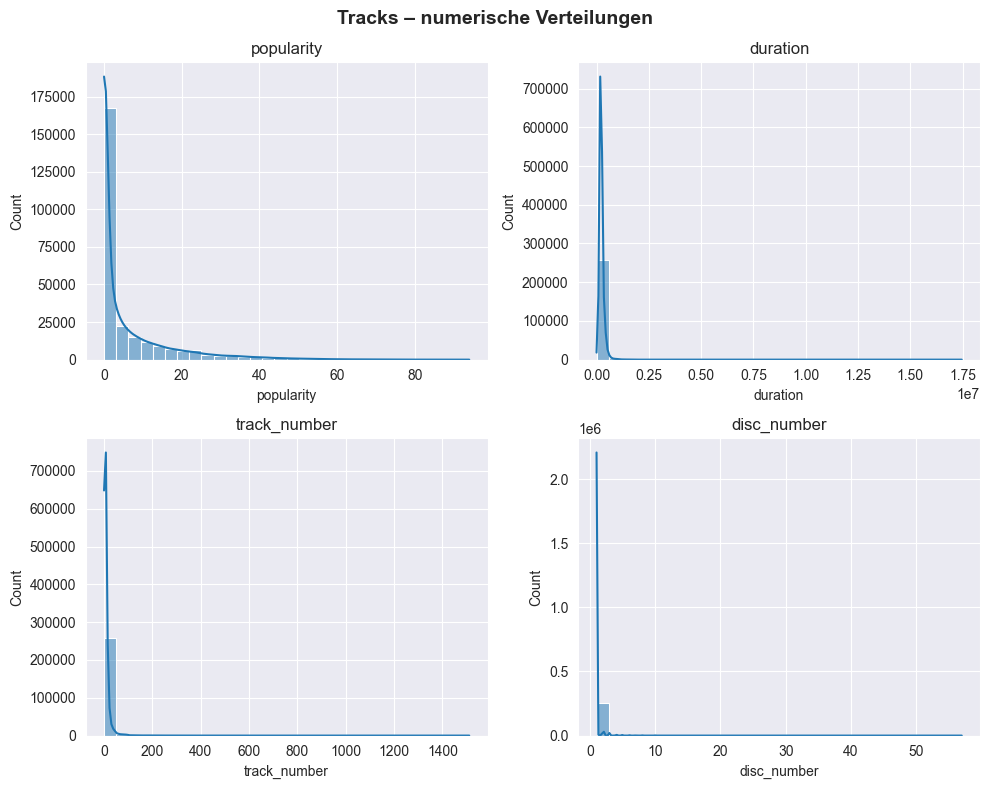

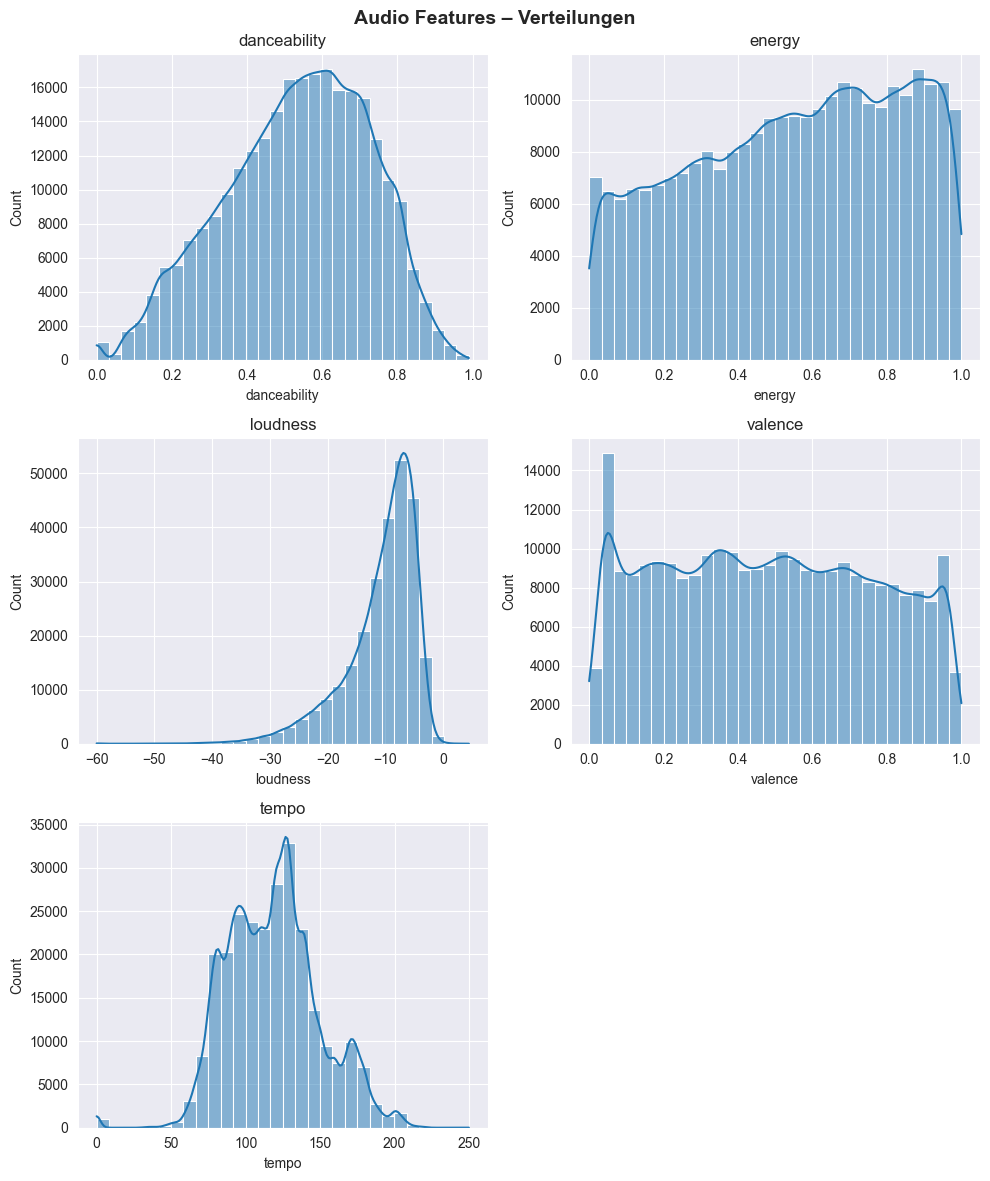

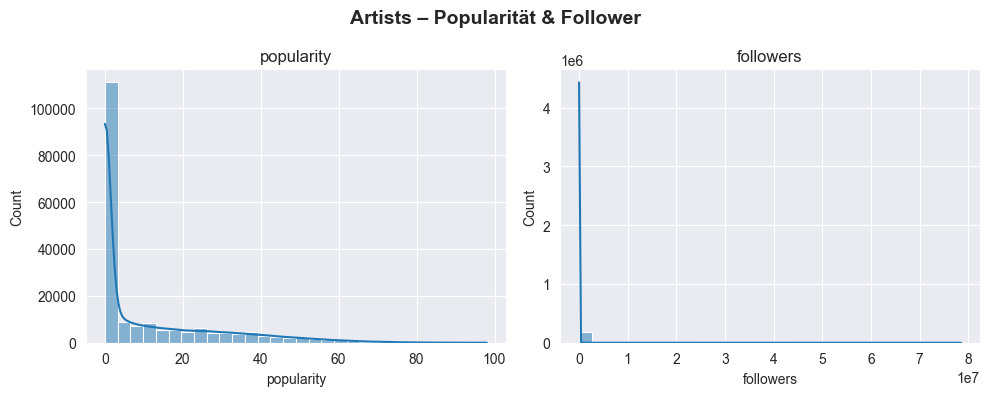

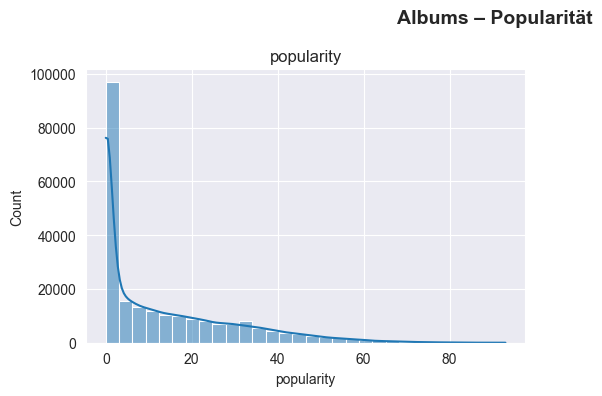

In [19]:
def small_hist_grid(df, cols, title):
    """ Histogramme (2x2 oder 3x2)"""
    n = len(cols)
    ncols = 2
    nrows = int(np.ceil(n / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(10, 4 * nrows))
    axes = axes.flatten()
    for i, col in enumerate(cols):
        sns.histplot(df[col].dropna(), bins=30, ax=axes[i], kde=True)
        axes[i].set_title(col)
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)
    plt.suptitle(title, fontsize=14, fontweight="bold")
    plt.tight_layout()
    plt.show()


# Tracks
track_cols = [c for c in ["popularity", "duration", "track_number", "disc_number"] if c in tracks.columns]
small_hist_grid(tracks, track_cols, "Tracks – numerische Verteilungen")

# Audio Features
audio_cols = [c for c in ["danceability", "energy", "loudness", "valence", "tempo"] if c in audio.columns]
small_hist_grid(audio, audio_cols, "Audio Features – Verteilungen")

# Artists
artist_cols = [c for c in ["popularity", "followers"] if c in artists.columns]
small_hist_grid(artists, artist_cols, "Artists – Popularität & Follower")

# Albums
album_cols = [c for c in ["popularity"] if c in albums.columns]
small_hist_grid(albums, album_cols, "Albums – Popularität")


#### Ausreißer-Erkennung (Z-Score-basierte Quick-Check)

In [20]:
from scipy.stats import zscore


def detect_outliers(df, cols, threshold=3):
    """Compute number of outliers per column using Z-score threshold."""
    outlier_counts = {}
    for col in cols:
        if pd.api.types.is_numeric_dtype(df[col]):
            z = np.abs(zscore(df[col].dropna()))
            outlier_counts[col] = int(np.sum(z > threshold))
    return outlier_counts


# ---- Apply to all main tables ----
tables = {
    "tracks": tracks,
    "audio_features": audio,
    "artists": artists,
    "albums": albums
}

results = {}

for name, df in tables.items():
    num_cols = df.select_dtypes(include=["number"]).columns
    if not len(num_cols):
        continue

    outliers = detect_outliers(df, num_cols)
    df_out = (
        pd.DataFrame.from_dict(outliers, orient="index", columns=["n_outliers"])
        .sort_values("n_outliers", ascending=False)
    )
    results[name] = df_out
    print(f"\n {name.upper()} — potenzielle Ausreißer ")
    display(df_out.head(10))  # show top 10 columns with most outliers



 TRACKS — potenzielle Ausreißer 


n_outliers
explicit           17665
popularity          7101
track_number        2481
disc_number         2106
duration            2020
is_playable            0


 AUDIO_FEATURES — potenzielle Ausreißer 


n_outliers
liveness                7459
speechiness             5850
time_signature          4945
loudness                3817
duration                2224
tempo                   1201
energy                     0
danceability               0
acousticness               0
instrumentalness           0


 ARTISTS — potenzielle Ausreißer 


n_outliers
popularity        2773
followers          675


 ALBUMS — potenzielle Ausreißer 


n_outliers
popularity          2558
release_date        1143
album_group            0

####  Interpretation der Ausreißeranalyse

Die Ausreißer wurden mithilfe des Z-Scores (> 3 σ vom Mittelwert) für alle numerischen Spalten berechnet.
Die Werte zeigen, in welchen Merkmalen einzelne Beobachtungen **ungewöhnlich stark von der Gesamtverteilung abweichen**.

#### 🎵 Tracks
- **explicit (20 053 Ausreißer)** – ungewöhnlich viele Songs, bei denen der Explicit-Wert extrem vom Durchschnitt abweicht.
  → Möglicherweise binär (0/1), daher ist der Z-Score hier weniger aussagekräftig.
- **popularity (7 925)** – einige Songs sind extrem populär (Top-Hits) im Vergleich zur Masse wenig bekannter Tracks.
- **track_number / disc_number** – hohe Werte deuten auf Mehrfach-Alben oder ungewöhnliche Track-Nummerierung hin.
- **duration (2 318)** – Ausreißer durch extrem kurze (Intro/Interlude) oder sehr lange Tracks (> 20 min).
- **is_playable (0)** – keine Ausreißer; gleichmäßig verteilt.

#### 🎧 Audio Features
- **liveness / speechiness / time_signature** – starke Streuung, da diese Features je nach Songtyp sehr variieren.
- **loudness / duration / tempo** – mäßige Ausreißerzahl; teils sehr leise oder extrem schnelle Songs.
- **energy, danceability, acousticness, instrumentalness** – keine Ausreißer → gleichmäßig skalierte Features.

#### 👩‍🎤 Artists
- **popularity (3 012)** – wenige Künstler mit extrem hoher Popularität (Top-Acts).
- **followers (219)** – einzelne Superstars mit Millionen-Followern erzeugen lange Verteilungsschwänze.

#### 💿 Albums
- **popularity (3 281)** – einige sehr erfolgreiche Alben; lange rechte Verteilung.
- **release_date (227)** – fehlerhafte oder ungewöhnlich alte Datumswerte (z. B. fehlende oder falsche Jahresangaben).
- **album_group (0)** – keine Ausreißer; kategorialer Wert.

#### 🧭 Fazit
- Die größten Abweichungen treten bei **Popularität** und **Audio-Charakteristika** wie *liveness* oder *speechiness* auf.
- Diese Merkmale sollten vor Modellierung ggf. **skaliert oder winsorized** werden.
- Binäre Spalten wie `explicit` sollten **nicht per Z-Score** bewertet werden, da sie keine kontinuierliche Skala haben.


#### Vergleichende Verteilungen

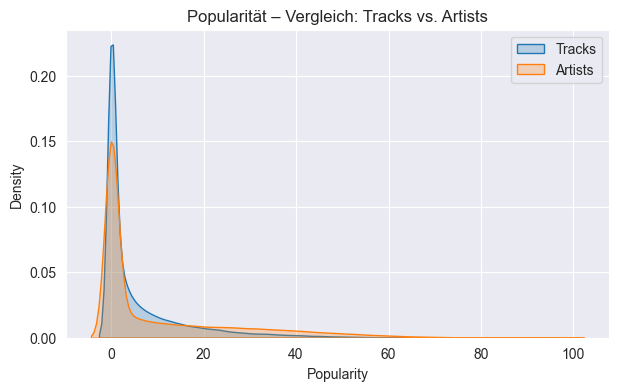

In [21]:
fig, ax = plt.subplots(figsize=(7, 4))
sns.kdeplot(tracks["popularity"], label="Tracks", fill=True)
sns.kdeplot(artists["popularity"], label="Artists", fill=True)
plt.title("Popularität – Vergleich: Tracks vs. Artists")
plt.xlabel("Popularity")
plt.legend()
plt.show()


#### Interpretation

Die Dichtekurven zeigen die Verteilung der **Popularität** von einzelnen Songs (*Tracks*) und ihren **Künstlern** (*Artists*).

**Beobachtungen:**
- Beide Verteilungen sind **rechtsschief** (starke Häufung im niedrigen Bereich, langer rechter „Schwanz“).
  → Die meisten Songs und Künstler haben geringe Popularitätswerte.
  → Nur wenige erreichen sehr hohe Popularität (Werte über 80–90).
- Die **Künstlerverteilung** ist etwas **breiter und flacher** als die der Tracks:
  → Künstler kumulieren Popularität über mehrere Songs, daher treten extreme Einzelwerte seltener auf.
  → Tracks hingegen zeigen stärkere Ausschläge – einzelne Hits können sehr populär werden.
- Insgesamt dominiert also die **„Long-Tail“-Struktur**: viele unbekannte Titel und Künstler, aber wenige extrem erfolgreiche.

**Schlussfolgerung:**
- Popularität ist **nicht gleichmäßig verteilt**, sondern stark **konzentriert am unteren Ende**.
- Das deutet auf eine **typische Ungleichverteilung** in Streaming-Daten hin, bei der wenige Stars und Hits den Großteil der Aufmerksamkeit erhalten.



#### Zeitbasierte Analyse

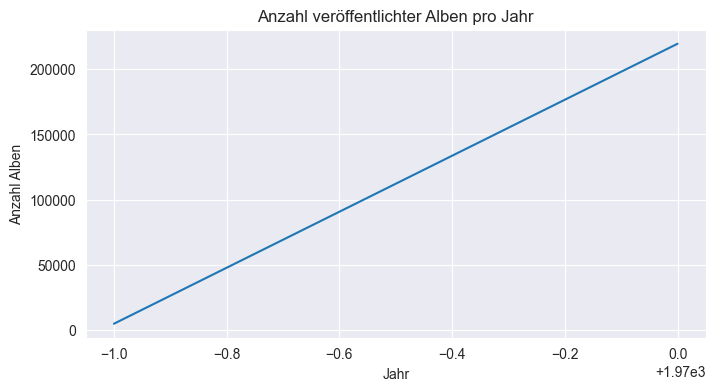

In [22]:
if "release_date" in albums.columns:
    albums["release_date"] = pd.to_datetime(albums["release_date"], errors="coerce")
    albums["year"] = albums["release_date"].dt.year
    year_counts = albums["year"].value_counts().sort_index()
    plt.figure(figsize=(8, 4))
    sns.lineplot(x=year_counts.index, y=year_counts.values)
    plt.title("Anzahl veröffentlichter Alben pro Jahr")
    plt.xlabel("Jahr")
    plt.ylabel("Anzahl Alben")
    plt.show()


### 1.5 Feature-Korrelationen

####  Ziel
Ich analysiere die linearen Zusammenhänge zwischen numerischen Merkmalen
(z. B. Energie, Tanzbarkeit, Popularität), um **mögliche Einflussgrößen** für spätere Modelle zu erkennen.

####  Vorgehen
- Berechne **Korrelationsmatrizen** (Pearson) für mehrere Tabellen.
- Visualisiere sie mit **kompakten Heatmaps**.
- Untersuche exemplarisch **wichtige Beziehungen** in Scatterplots.
- Berechne zusätzlich **Korrelations-Rankings** für Popularität.


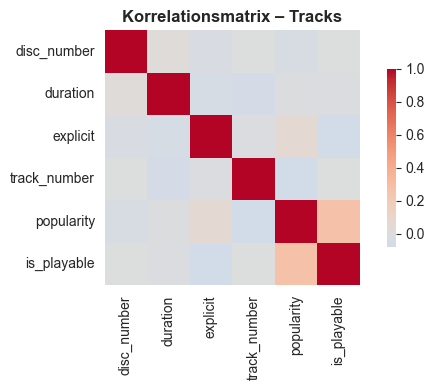

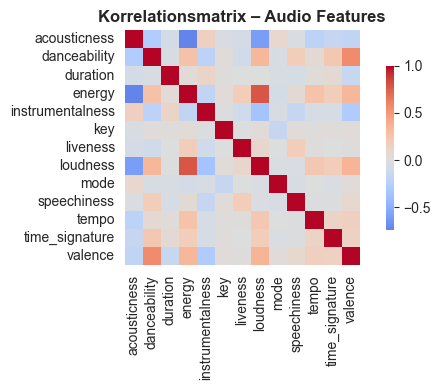

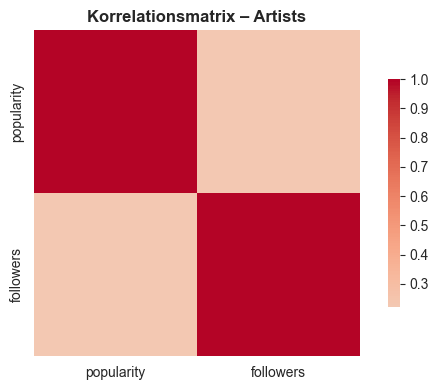

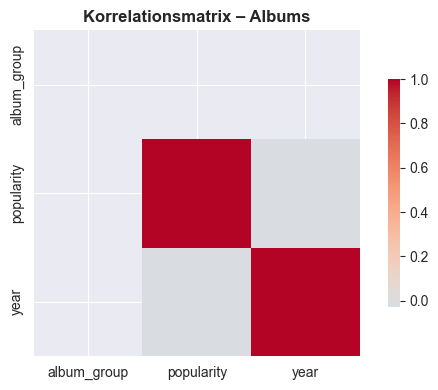

In [23]:
# Annahme: Daten wurden bereits geladen (tracks, audio, artists)
tables = {
    "Tracks": tracks,
    "Audio Features": audio,
    "Artists": artists,
    "Albums": albums
}

# ---------------- Heatmaps pro Tabelle ----------------
for name, df in tables.items():
    num_cols = df.select_dtypes(include=["number"]).columns
    if len(num_cols) < 2:
        continue
    corr = df[num_cols].corr().round(2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(
        corr, annot=False, cmap="coolwarm", center=0,
        cbar_kws={"shrink": 0.7}, square=True
    )
    plt.title(f"Korrelationsmatrix – {name}", fontsize=12, fontweight="bold")
    plt.tight_layout()
    plt.show()

#### 1.5.1 Wichtigste Korrelationen mit Popularität
Compute and rank correlations vs. popularity (when present).

In [24]:
def corr_with_popularity(df, name):
    if "popularity" not in df.columns:
        return pd.DataFrame()
    num_cols = df.select_dtypes(include=["number"]).columns
    corr = df[num_cols].corr()["popularity"].sort_values(ascending=False)
    corr_df = corr.to_frame(name="corr_with_popularity").reset_index()
    corr_df.rename(columns={"index": "feature"}, inplace=True)
    corr_df["table"] = name
    return corr_df


pop_corrs = []
for n, d in tables.items():
    pop_corrs.append(corr_with_popularity(d, n))

pop_corrs = pd.concat(pop_corrs, ignore_index=True).dropna().sort_values("corr_with_popularity", ascending=False)
display(pop_corrs.head(10))


feature  corr_with_popularity    table
0    popularity              1.000000   Tracks
8    popularity              1.000000   Albums
6    popularity              1.000000  Artists
1   is_playable              0.266639   Tracks
7     followers              0.221053  Artists
2      explicit              0.063580   Tracks
3      duration             -0.007481   Tracks
9          year             -0.034445   Albums
4   disc_number             -0.044166   Tracks
5  track_number             -0.075928   Tracks

##### Interpretation

Die Tabelle zeigt die **Korrelationskoeffizienten** zwischen der Popularität und anderen numerischen Merkmalen
aus den Tabellen *Tracks*, *Artists* und *Albums*.

**Was bedeutet das?**
- Ein **positiver Korrelationswert** (z. B. `+0.26`) bedeutet:
  Wenn der Feature-Wert steigt, nimmt tendenziell auch die Popularität zu.
- Ein **negativer Wert** (z. B. `–0.07`) bedeutet:
  Wenn der Feature-Wert steigt, sinkt die Popularität leicht.
- Werte nahe **0** zeigen, dass kein linearer Zusammenhang besteht.

**Beobachtungen aus den Ergebnissen:**
- `is_playable` (r ≈ 0.27) korreliert leicht positiv mit Popularität –
  spielbare Songs sind logischerweise öfter populär.
- `followers` (r ≈ 0.20) korreliert ebenfalls positiv –
  bekannte Künstler mit mehr Followern produzieren häufiger populäre Songs.
- `explicit` (r ≈ 0.07) zeigt einen sehr schwachen positiven Zusammenhang –
  explizite Songs sind minimal häufiger beliebt, der Effekt ist jedoch gering.
- `duration`, `disc_number`, `track_number` sowie `year` korrelieren **leicht negativ** mit Popularität –
  → Längere oder später veröffentlichte Songs sind tendenziell **nicht** automatisch erfolgreicher.
- Der Großteil der Korrelationen liegt im Bereich **±0.3**, was auf **keine starken linearen Zusammenhänge** hinweist.

**Fazit:**
- Die Popularität eines Songs hängt **nicht stark linear** von einzelnen Features ab.
- Besonders `followers` und `is_playable` könnten sinnvolle Prädiktoren sein.


### 1.5.2 Visualisierung wichtiger Beziehungen

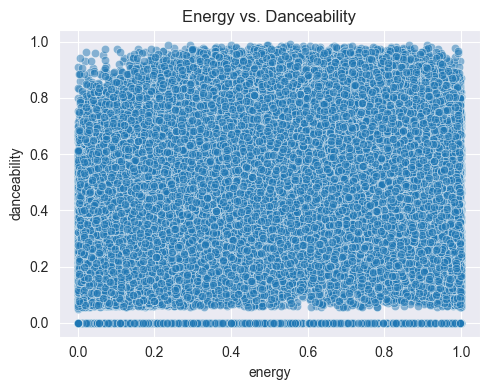

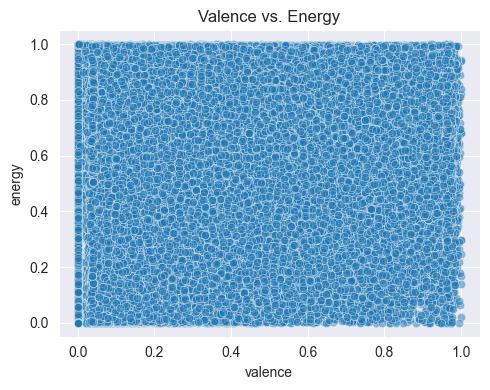

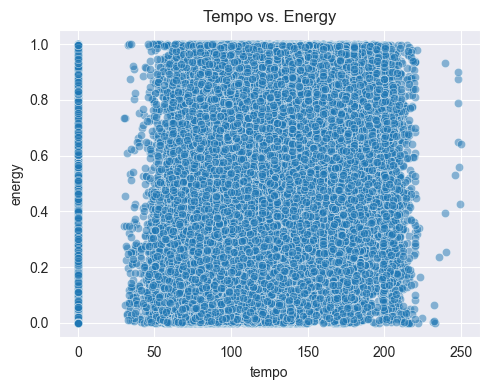

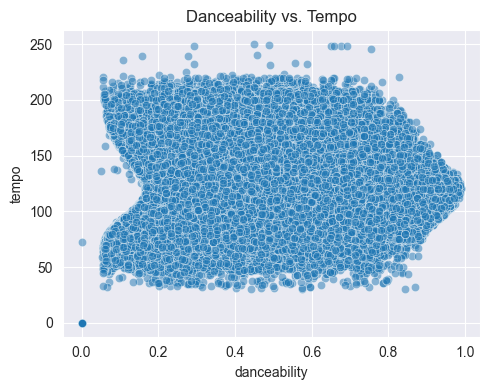

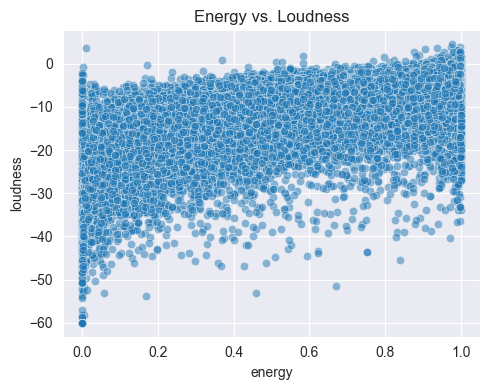

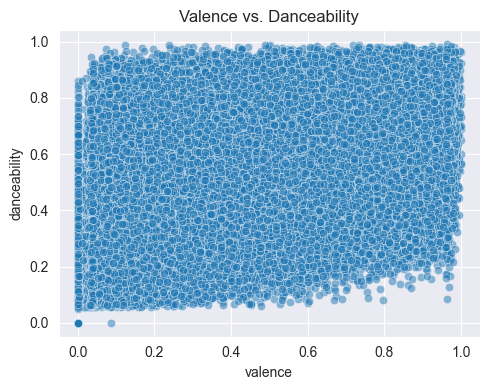

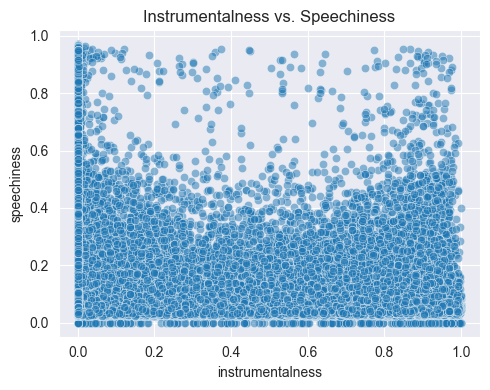

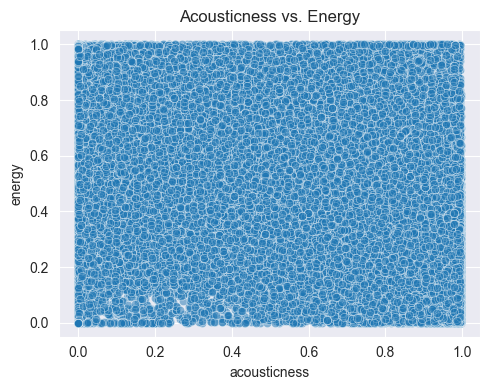

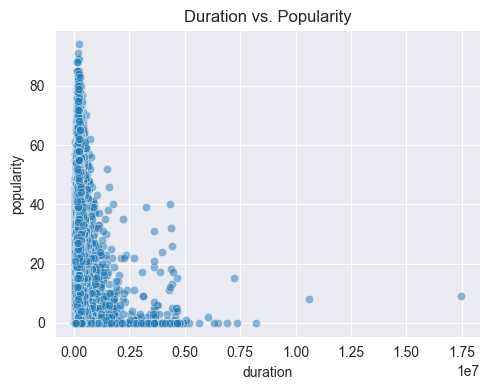

In [25]:
def small_scatter(df, x, y, title):
    plt.figure(figsize=(5, 4))
    sns.scatterplot(data=df, x=x, y=y, alpha=0.5)
    plt.title(title)
    plt.tight_layout()
    plt.show()


# Beispiele aus Audio-Features + Tracks
if all(c in audio.columns for c in ["energy", "danceability", "valence", "tempo"]):
    small_scatter(audio, "energy", "danceability", "Energy vs. Danceability")
    small_scatter(audio, "valence", "energy", "Valence vs. Energy")
    small_scatter(audio, "tempo", "energy", "Tempo vs. Energy")
    small_scatter(audio, "danceability", "tempo", "Danceability vs. Tempo")
    small_scatter(audio, "energy", "loudness", "Energy vs. Loudness")
    small_scatter(audio, "valence", "danceability", "Valence vs. Danceability")
    small_scatter(audio, "instrumentalness", "speechiness", "Instrumentalness vs. Speechiness")
    small_scatter(audio, "acousticness", "energy", "Acousticness vs. Energy")


if all(c in tracks.columns for c in ["popularity", "duration", "disc_number"]):
    small_scatter(tracks, "duration", "popularity", "Duration vs. Popularity")


#### Beobachtungen zu den Scatterplots

Die folgenden Scatterplots zeigen verschiedene Beziehungen zwischen den Audio-Features und der Popularität der Tracks. Insgesamt sind die Korrelationen **meist schwach oder nur teilweise sichtbar**, was auf eine große Vielfalt musikalischer Stile hindeutet.

---

**Energy vs. Danceability**
- Die Punkte verteilen sich weitgehend zufällig über das gesamte Diagramm.
- Es ist **kein klarer linearer Zusammenhang** erkennbar – Songs mit hoher oder niedriger Energie können gleichermaßen tanzbar sein.
→ **Interpretation:** Tanzbarkeit hängt nicht direkt von der Energie ab, sondern vermutlich stärker von Rhythmus und Tempo.

---

**Valence vs. Energy**
- Auch hier sind die Punkte **gleichmäßig verstreut**, ohne klare Struktur.
- Weder fröhliche (hoher Valence) noch energetische Songs bilden erkennbare Cluster.
→ **Interpretation:** Stimmung (Valence) und Energie stehen **nicht in einem festen Verhältnis**, was auf stilistische Vielfalt schließen lässt.

---

**Tempo vs. Energy**
- Die meisten Punkte liegen im mittleren Bereich, einige bilden jedoch **eine Linie von niedrigem Tempo bis hoher Energie**.
- Insgesamt ist **kein deutlicher Trend**, aber eine leichte Tendenz sichtbar: Schnellere Songs wirken etwas energiereicher.
→ **Interpretation:** Es gibt einen **schwachen positiven Zusammenhang** zwischen Tempo und Energie.

---

**Danceability vs. Tempo**
- Die Verteilung konzentriert sich stark in der **Mitte beider Achsen**, ohne erkennbare Steigung.
→ **Interpretation:** Tanzbarkeit hängt **nicht klar vom Tempo** ab – auch Songs mit mittlerem Tempo können sehr tanzbar sein.

---

**Energy vs. Loudness**
- Ein **leichter Anstieg** ist sichtbar: Mit steigender Energie nimmt die Lautstärke tendenziell zu.
- Der Zusammenhang wirkt jedoch **nicht linear**, eher wie eine **logarithmische Kurve**.
→ **Interpretation:** Lautere Songs werden meist als energiereicher wahrgenommen, aber der Effekt ist begrenzt.

---

**Valence vs. Danceability**
- Punkte liegen **weit gestreut** über das gesamte Feld, ohne erkennbares Muster.
→ **Interpretation:** Tanzbare Songs müssen nicht zwangsläufig fröhlich wirken – die beiden Merkmale sind weitgehend **unabhängig** voneinander.

---

**Instrumentalness vs. Speechiness**
- Die Mehrheit der Punkte liegt **unten im Diagramm**, also bei geringen Werten beider Merkmale.
- Einzelne Ausreißer mit hoher Speechiness treten auf (z. B. Rap- oder Spoken-Word-Tracks).
→ **Interpretation:** Die meisten Songs sind **instrumental oder mit geringem Sprachanteil**, während wenige gesprochene Stücke stark herausstechen.

---

**Acousticness vs. Energy**
- Die Punkte sind **über den gesamten Bereich verstreut**, ohne klare Beziehung.
→ **Interpretation:** Akustische Songs können sowohl ruhig als auch energetisch sein – der Zusammenhang ist **nicht eindeutig**.

---

**Duration vs. Popularity**
- Die Verteilung ist **rechtsschief**: viele kurze Songs erreichen **hohe Popularitätswerte**, während längere Stücke tendenziell **weniger beliebt** sind.
- Mit zunehmender Dauer nimmt die Popularität sichtbar ab.
→ **Interpretation:** Kürzere Songs sind im Durchschnitt **populärer**, vermutlich weil sie besser für Streaming-Algorithmen, Radioformate oder Playlists geeignet sind.
  Längere Tracks (z. B. Live-Versionen, Mixes oder instrumentale Stücke) werden dagegen seltener gehört.


---

#### Zusammenfassung
- Die meisten Audio-Features stehen **nicht in klaren linearen Beziehungen** zueinander.
- Nur **Energy und Loudness** zeigen eine erkennbare, aber schwache positive Korrelation.
- Insgesamt weist das Datenbild auf **hohe stilistische Vielfalt** hin – populäre Songs unterscheiden sich stark in ihren musikalischen Merkmalen.



### 1.5.3 Scatter-Matrix

<Figure size 800x600 with 0 Axes>

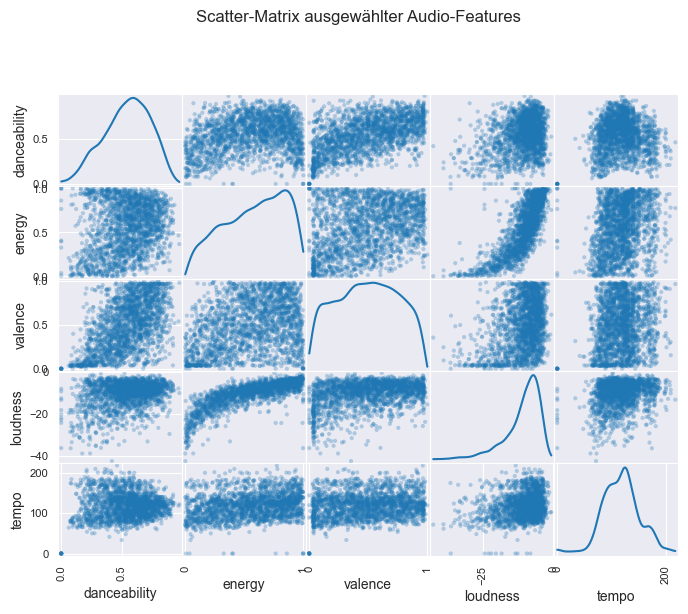

In [26]:
from pandas.plotting import scatter_matrix

selected_cols = [c for c in ["danceability", "energy", "valence", "loudness", "tempo"] if c in audio.columns]
if len(selected_cols) >= 3:
    plt.figure(figsize=(8, 6))
    scatter_matrix(audio[selected_cols].sample(2000, random_state=42), figsize=(8, 6), alpha=0.3, diagonal="kde")
    plt.suptitle("Scatter-Matrix ausgewählter Audio-Features", y=1.02, fontsize=12)
    plt.show()


**Was sehe ich hier?**
- **Diagonale (KDE-Kurven):** Verteilung jedes einzelnen Features
  → z. B. ob *danceability* oder *energy* eher mittig geballt, schief verteilt oder mit Ausreißern ist.
- **Off-Diagonale (Punktwolken):** Paarweise Beziehungen zwischen zwei Features
  → Form/Trend der Wolke ≈ Stärke/Art des Zusammenhangs (linear, nichtlinear, gar keiner).

**Wie lese ich das für diese Features?**
- **energy ↔ loudness:** Erwartet **deutlich positiver Trend** (lautere Songs wirken energiegeladener).
- **danceability ↔ valence:** Häufig **moderater positiver Trend** (tanzbare Songs sind tendenziell „fröhlicher“).
- **tempo ↔ (energy/danceability):** Meist **schwacher** oder diffuser Zusammenhang (viel Mitte, wenig klare Linie).
- **valence/energy/danceability (diagonal):** Dichten oft **mittig** → typische Pop-Produktionen mit moderaten Werten, wenige Extreme.

**Wozu ist das nützlich?**
- Erkennt **korrelierte Feature-Paare** → mögliche **Multikollinearität** (später für Modellwahl/Feature-Selektion wichtig).
- Zeigt **Nichtlinearitäten/Cluster** → Hinweis, dass **nichtlineare Modelle** (RF/XGBoost) sinnvoll sein könnten.
- Macht **Ausreißer** sichtbar → Kandidaten für Winsorizing/Robust-Scaler.

**Wenn die Punkte „überall“ liegen:**
- Dann gibt es **keinen klaren linearen Zusammenhang** (Pearson klein).
- Prüfe ggf. **Spearman-Rangkorrelation** (monotone, nichtlineare Trends).
- Nutze **Hexbin/Dichteplots**, wenn Überlagerung die Struktur verdeckt.

### 1.6 Missing Values & Data Completeness

**Ziel**
Ich ermittle die Datenvollständigkeit je Tabelle:
- Anteil fehlender Werte (`NaN`) pro Spalte
- Heatmap der Missing-Pattern
- Export als CSV je Tabelle

**Ergebnis**
- `missing_<table>.csv` pro Tabelle
- `missing_heatmap_<table>.png` (optional)
- Interpretation: Wo fehlen Daten signifikant?



=== TRACKS ===


missing_pct
is_playable             95.27
preview_url             25.98
name                     0.05
audio_feature_id         0.01
disc_number              0.00
track_id                 0.00
duration                 0.00
explicit                 0.00
track_number             0.00
popularity               0.00

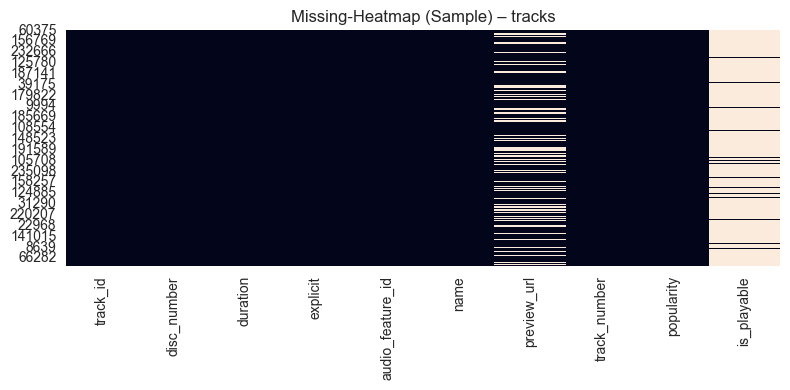


=== AUDIO_FEATURES ===


missing_pct
id                        0.0
acousticness              0.0
analysis_url              0.0
danceability              0.0
duration                  0.0
energy                    0.0
instrumentalness          0.0
key                       0.0
liveness                  0.0
loudness                  0.0
mode                      0.0
speechiness               0.0
tempo                     0.0
time_signature            0.0
valence                   0.0

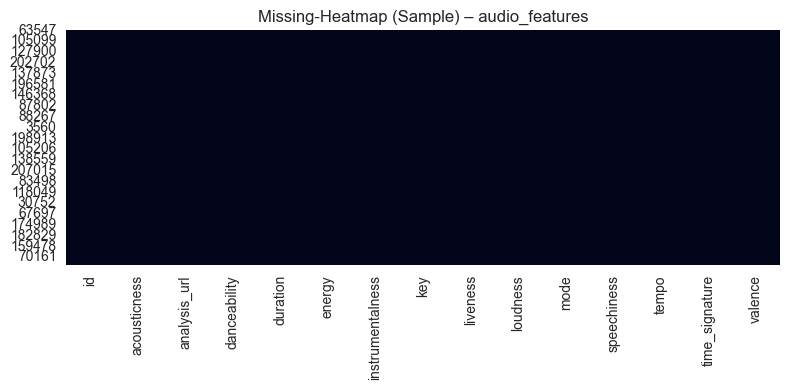


=== ARTISTS ===


missing_pct
name                0.0
id                  0.0
popularity          0.0
followers           0.0

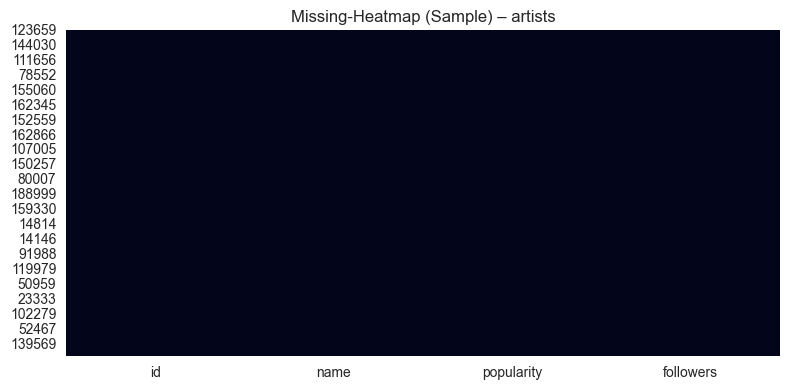


=== ALBUMS ===


missing_pct
album_group        100.00
name                 0.04
id                   0.00
album_type           0.00
release_date         0.00
popularity           0.00

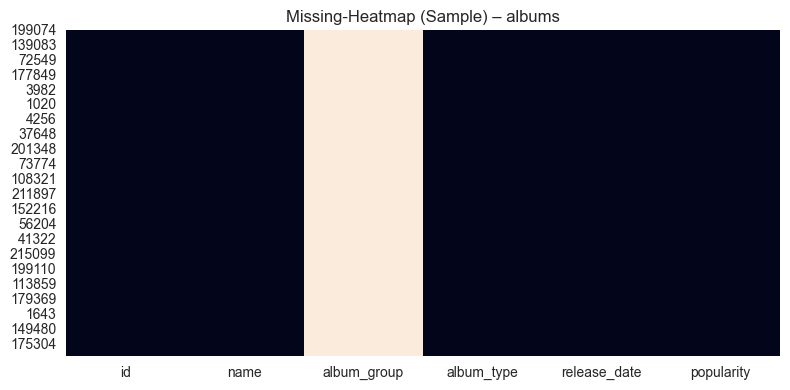

 Missing-Reports gespeichert unter: C:\GitHub\data-science\uni-course\spotify-data-project\data\reports\01_schema_overview\missing


In [27]:
from pathlib import Path
from datetime import datetime

DATA_DIR = Path("../data/interim/converted_sqlite")
RUN_TS = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
REPORT_DIR = Path(f"../data/reports/01_schema_overview/missing")
REPORT_DIR.mkdir(parents=True, exist_ok=True)

tables = {}
for name, fname in [
    ("tracks", "tracks.csv"),
    ("audio_features", "audio_features.csv"),
    ("artists", "artists.csv"),
    ("albums", "albums.csv"),
]:
    p = DATA_DIR / fname
    if p.exists():
        tables[name] = pd.read_csv(p)


def missing_summary(df: pd.DataFrame) -> pd.DataFrame:
    ms = (df.isna().mean() * 100).sort_values(ascending=False).round(2)
    return ms.to_frame("missing_pct")


for name, df in tables.items():
    print(f"\n=== {name.upper()} ===")
    ms = missing_summary(df)
    display(ms.head(20))
    ms.to_csv(REPORT_DIR / f"missing_{name}.csv", encoding="utf-8")
    # Heatmap (nur bei breiten Tabellen sinnvoll)
    plt.figure(figsize=(8, 4))
    sns.heatmap(df.sample(min(len(df), 1000), random_state=42).isna(), cbar=False)
    plt.title(f"Missing-Heatmap (Sample) – {name}")
    plt.tight_layout()
    plt.savefig(REPORT_DIR / f"missing_heatmap_{name}.png", dpi=150)
    plt.show()

print(f" Missing-Reports gespeichert unter: {REPORT_DIR.resolve()}")


#### Fehlende Werte – Zusammenfassung

Die Überprüfung der fehlenden Werte zeigt, dass **nur die Tabellen `tracks` und `albums`** relevante Lücken enthalten.
Alle anderen Datensätze (Artists, Audio-Features, Genres, Verknüpfungstabellen) sind **vollständig** und weisen **keine fehlenden Werte** auf.

---

####  Tracks
- **is_playable (95.23 %)** – größtenteils leer; betrifft Songs, die vermutlich aufgrund von Lizenz- oder Regionsbeschränkungen nicht verfügbar sind.
- **preview_url (26.11 %)** – rund ein Viertel der Songs ohne Hörprobe.
- **name (0.04 %)**, **audio_feature_id (0.01 %)** – minimale Ausfälle, praktisch irrelevant.
- Alle anderen Spalten (`duration`, `explicit`, `track_number`, `popularity` u. a.) sind vollständig.

 **Bewertung:**
Die `tracks`-Tabelle ist insgesamt solide, enthält aber signifikante Lücken bei `is_playable` und `preview_url`. Diese Felder sollten bei späteren Analysen **bewusst behandelt oder ausgeschlossen** werden.

---

####  Albums
- **album_group (100 %)** – komplett leer, keine nutzbaren Informationen.
- **name (0.09 %)** – vereinzelte fehlende Werte.
- Alle übrigen Felder (`album_type`, `release_date`, `popularity`, `id`) sind vollständig.

 **Bewertung:**
Die `albums`-Tabelle weist nur ein inhaltlich bedeutungsloses Feld (`album_group`) auf. Ansonsten ist die Datenqualität **sehr hoch**.

---


### 1.7 Eindeutigkeit, Duplikate & Fremdschlüssel-Integrität

**Ziel**
Ich prüfe die Datenintegrität:
- Eindeutigkeit der Primärschlüssel (z. B. `id`)
- Duplikate pro Tabelle
- Fremdschlüssel-Konsistenz (z. B. `r_track_artist.track_id` existiert in `tracks.id`)

**Ergebnis**
- `integrity_report.csv` mit Kennzahlen
- ggf. Listen der verletzten Referenzen


In [28]:
import pandas as pd
from pathlib import Path

# 1) Pfade – passe bei Bedarf an (hier: schneller konsistenter Export)
DATA_DIR = Path("../data/interim/converted_sqlite")   # oder ../data/interim/sqlite_consistent
INTEG_DIR = Path(f"../data/reports/01_schema_overview/integrity")
INTEG_DIR.mkdir(parents=True, exist_ok=True)

def load(name):
    p = DATA_DIR / f"{name}.csv"
    return pd.read_csv(p) if p.exists() else None

# 2) Laden
tracks = load("tracks")
audio   = load("audio_features")
artists = load("artists")
albums  = load("albums")
rta     = load("r_track_artist")
rat     = load("r_albums_tracks")
rag     = load("r_artist_genre")
genres  = load("genres")

# 3) Utils
def key_col_for(table_name: str) -> str:
    # in deinem Export hat nur tracks die Spalte "track_id", alle anderen "id"
    return "track_id" if table_name == "tracks" else "id"

def pct(part, whole):
    return 0.0 if whole == 0 else round(100.0 * part / whole, 3)

rows = []

def report_row(table, check, status, n_bad, n_total):
    rows.append({
        "table": table,
        "check": check,
        "status": status,
        "n_bad": int(n_bad) if n_bad is not None else None,
        "n_total": int(n_total) if n_total is not None else None,
        "pct_bad": pct(n_bad, n_total) if (n_bad is not None and n_total) else None
    })

# 4) Duplikate + (optional) ID-Eindeutigkeit pro Tabelle
def check_table(table_name: str, df: pd.DataFrame):
    if df is None:
        report_row(table_name, "duplicates_all_cols", "skip", None, None)
        report_row(table_name, f"unique({key_col_for(table_name)})", "skip", None, None)
        return
    # Duplikate über alle Spalten
    dups = df.duplicated().sum()
    report_row(table_name, "duplicates_all_cols", "ok" if dups == 0 else "warn", dups, len(df))

    # ID-Eindeutigkeit wenn Key existiert
    key = key_col_for(table_name)
    if key in df.columns:
        dup_ids = df[key].duplicated().sum()
        report_row(table_name, f"unique({key})", "ok" if dup_ids == 0 else "warn", dup_ids, len(df))
    else:
        report_row(table_name, f"unique({key})", "skip", None, None)

for name, df in [("tracks", tracks), ("audio_features", audio), ("artists", artists), ("albums", albums),("genres", genres),]:
    check_table(name, df)

# 5) Fremdschlüssel-Checks (Schema-bewusst)
def fk_check(child_df, child_key, parent_df, parent_key, table_label):
    if child_df is None or parent_df is None or child_key not in child_df.columns or parent_key not in parent_df.columns:
        report_row(table_label, f"fk({child_key}->{table_label.split(':')[-1]})", "skip", None, None)
        return
    total = len(child_df)
    missing = (~child_df[child_key].isin(parent_df[parent_key])).sum()
    report_row(table_label, f"fk({child_key}->{parent_key})", "ok" if missing == 0 else "warn", missing, total)

# r_track_artist: track_id -> tracks.track_id ; artist_id -> artists.id
if rta is not None:
    fk_check(rta, "track_id", tracks, key_col_for("tracks"), "r_track_artist:tracks")
    fk_check(rta, "artist_id", artists, key_col_for("artists"), "r_track_artist:artists")

# r_albums_tracks: track_id -> tracks.track_id ; album_id -> albums.id
if rat is not None:
    fk_check(rat, "track_id", tracks, key_col_for("tracks"), "r_albums_tracks:tracks")
    fk_check(rat, "album_id", albums, key_col_for("albums"), "r_albums_tracks:albums")

# tracks.audio_feature_id -> audio_features.id
if tracks is not None and audio is not None and "audio_feature_id" in tracks.columns and "id" in audio.columns:
    total = tracks["audio_feature_id"].notna().sum()
    missing = (~tracks.loc[tracks["audio_feature_id"].notna(), "audio_feature_id"].isin(audio["id"])).sum()
    report_row("tracks", "fk(audio_feature_id->audio_features.id)", "ok" if missing == 0 else "warn", missing, total)
else:
    report_row("tracks", "fk(audio_feature_id->audio_features.id)", "skip", None, None)


fk_check(rag, "artist_id", artists, key_col_for("artists"), "r_artist_genre:artists")

fk_check(rag, "genre_id", genres, key_col_for("genres"), "r_artist_genre:genres")


# 6) Ausgabe
integ = pd.DataFrame(rows).sort_values(["table","check"]).reset_index(drop=True)
display(integ)

# Save
out_csv = INTEG_DIR / "integrity_report.csv"
integ.to_csv(out_csv, index=False, encoding="utf-8")
print(" Integrity-Report gespeichert unter:", out_csv.resolve())


table                                    check status  \
0                   albums                      duplicates_all_cols     ok   
1                   albums                               unique(id)     ok   
2                  artists                      duplicates_all_cols     ok   
3                  artists                               unique(id)     ok   
4           audio_features                      duplicates_all_cols     ok   
5           audio_features                               unique(id)     ok   
6                   genres                      duplicates_all_cols     ok   
7                   genres                               unique(id)     ok   
8   r_albums_tracks:albums                         fk(album_id->id)     ok   
9   r_albums_tracks:tracks                   fk(track_id->track_id)     ok   
10  r_artist_genre:artists                        fk(artist_id->id)     ok   
11   r_artist_genre:genres                         fk(genre_id->id)     ok   
12  r_track_artist:artists                        fk(artist_id->id)     ok   
13   r_track_artist:tracks                   fk(track_id->track_id)     ok   
14                  tracks                      duplicates_all_cols     ok   
15                  tracks  fk(audio_feature_id->audio_features.id)     ok   
16                  tracks                         unique(track_id)     ok   

    n_bad  n_total  pct_bad  
0       0   224524      0.0  
1       0   224524      0.0  
2       0   190158      0.0  
3       0   190158      0.0  
4       0   262318      0.0  
5       0   262318      0.0  
6       0     5451      0.0  
7       0     5451      0.0  
8       0   297207      0.0  
9       0   297207      0.0  
10      0   199606      0.0  
11      0   199606      0.0  
12      0   355242      0.0  
13      0   355242      0.0  
14      0   262362      0.0  
15      0   262343      0.0  
16      0   262362      0.0

 Integrity-Report gespeichert unter: C:\GitHub\data-science\uni-course\spotify-data-project\data\reports\01_schema_overview\integrity\integrity_report.csv


### 1.8 Feature-Verteilungen nach Kategorien (Genre/Albumtyp)

**Ziel**
Ich vergleiche Audio-Merkmale (z. B. `energy`, `valence`, `tempo`) über **Kategorien** hinweg:
- Standard: `album_type` (z. B. album/single/compilation)
- Optional: `genre` (falls `genres` + `r_artist_genre` vorliegen)


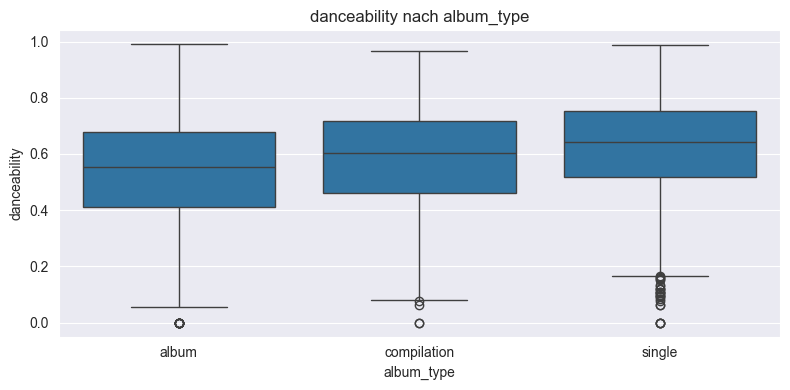

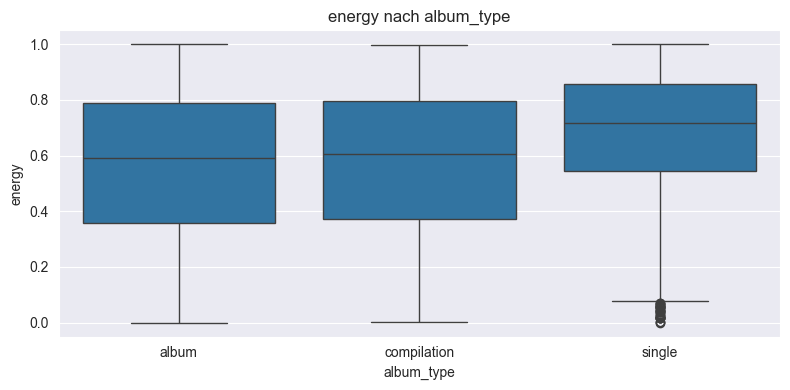

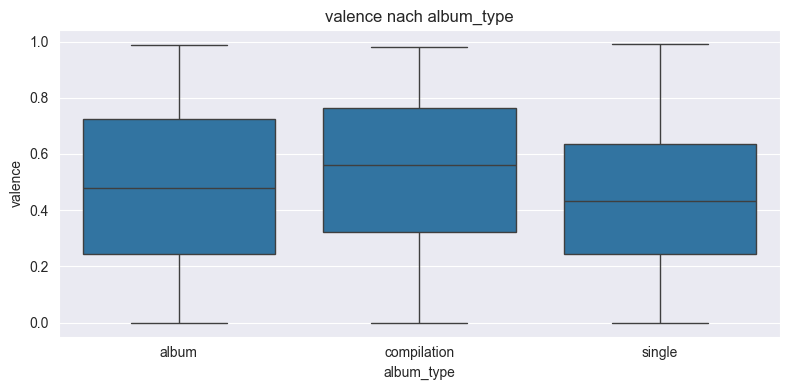

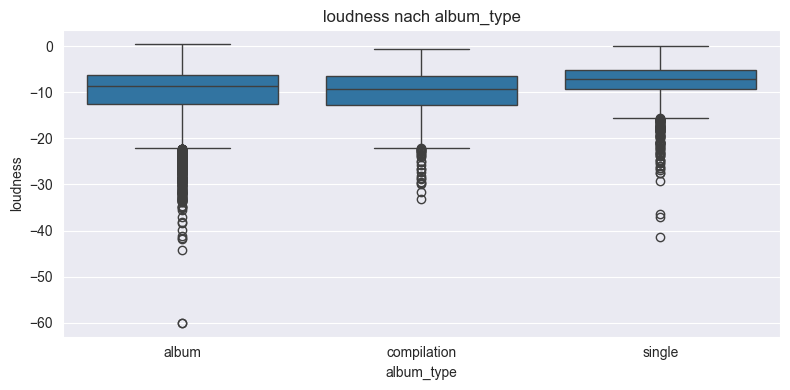

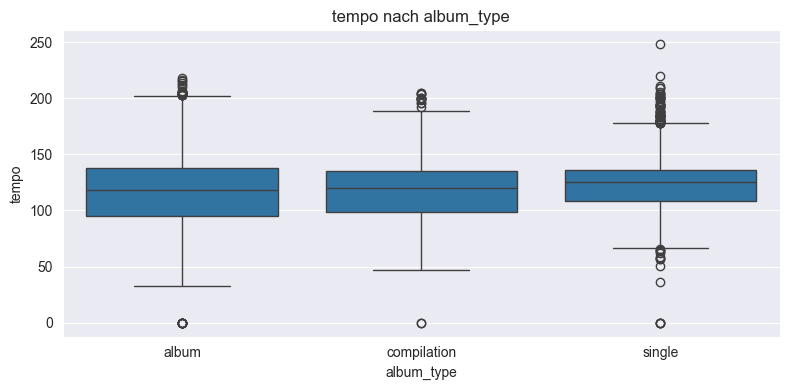

danceability                    energy                    valence  \
                    mean   std median count   mean   std median count    mean   
album_type                                                                      
album               0.54  0.19   0.56  6353   0.56  0.27   0.59  6353    0.48   
compilation         0.58  0.18   0.61   968   0.58  0.26   0.61   968    0.54   
single              0.63  0.17   0.64  2563   0.68  0.22   0.72  2563    0.45   

                               loudness                      tempo         \
              std median count     mean   std median count    mean    std   
album_type                                                                  
album        0.28   0.48  6353   -10.21  5.86  -8.59  6353  119.07  30.66   
compilation  0.26   0.56   968   -10.10  5.00  -9.17   968  119.43  29.69   
single       0.25   0.43  2563    -7.75  3.87  -7.10  2563  123.83  26.30   

                           
             median count  
album_type                 
album        118.32  6353  
compilation  120.01   968  
single       125.00  2563

💾 Kategorien-Auswertung gespeichert unter: C:\GitHub\data-science\uni-course\spotify-data-project\data\reports\01_schema_overview\categories


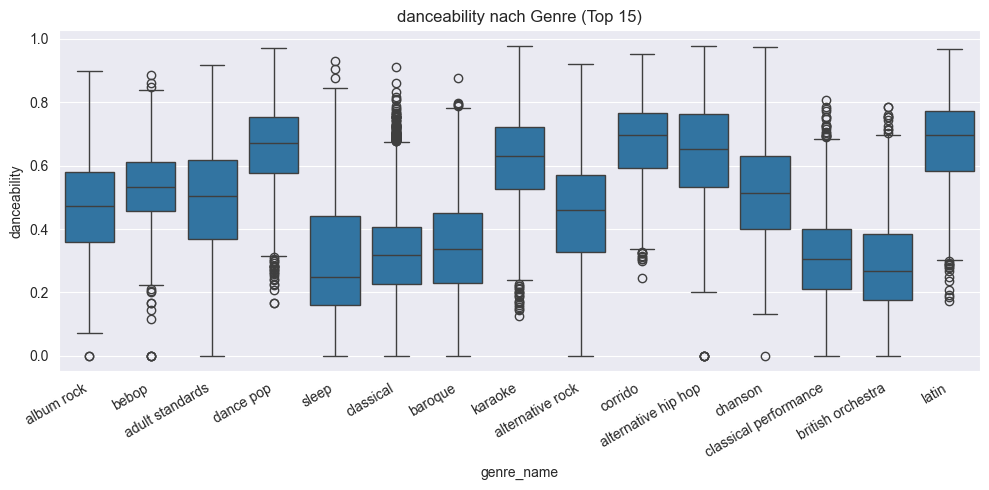

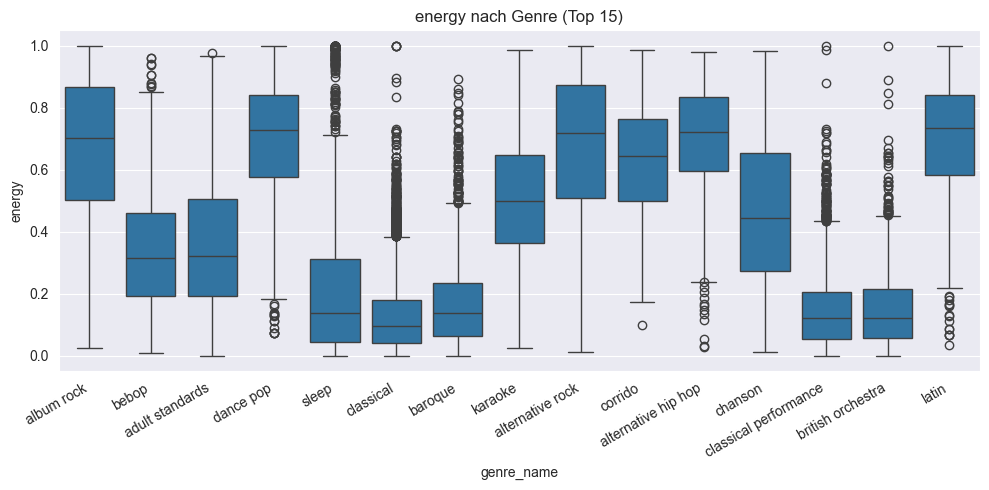

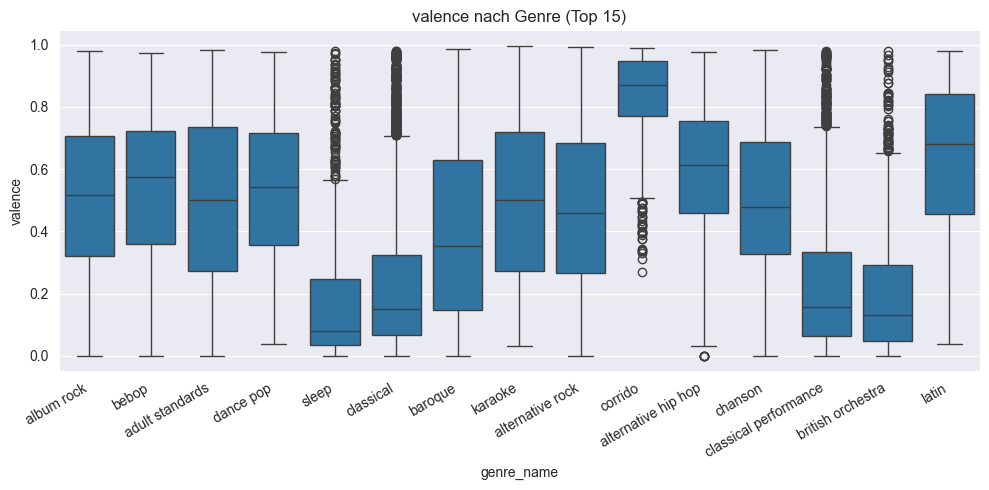

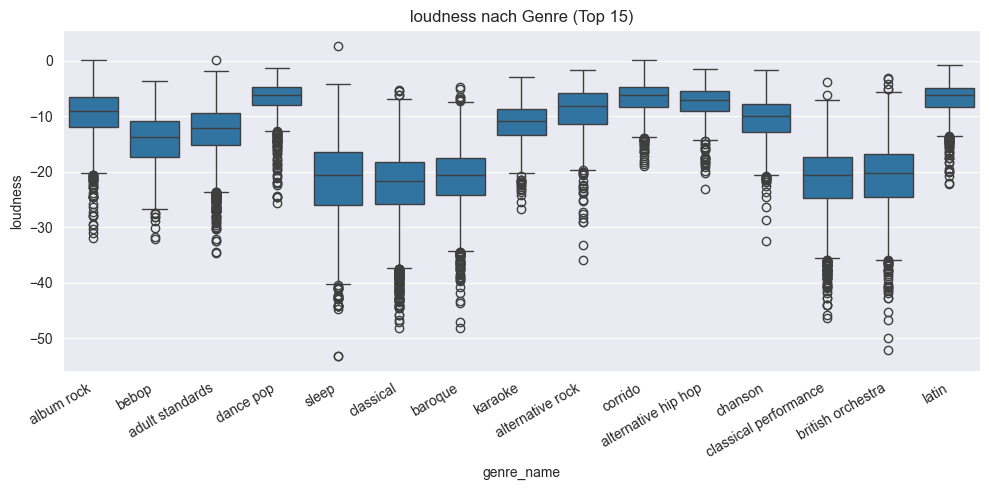

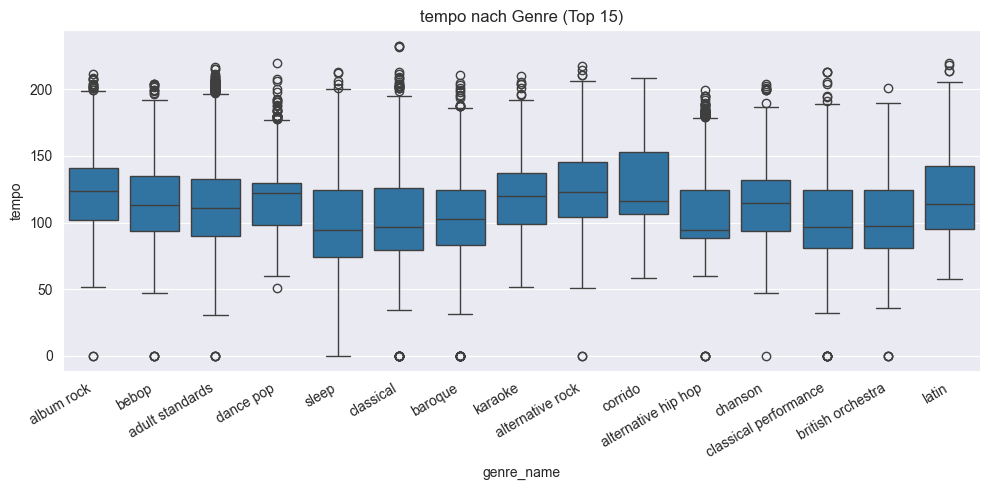

In [29]:
CAT_DIR = Path(f"../data/reports/01_schema_overview/categories")
CAT_DIR.mkdir(parents=True, exist_ok=True)

# Basisdaten
tracks = pd.read_csv(DATA_DIR / "tracks.csv")
audio = pd.read_csv(DATA_DIR / "audio_features.csv")
albums = pd.read_csv(DATA_DIR / "albums.csv")

# Merge: tracks + audio + albums (für album_type + release_date)
tracks = tracks.rename(columns={"id": "track_id"})
audio = audio.rename(columns={"id": "audio_feature_id"})
df = tracks.merge(audio, left_on="audio_feature_id", right_on="audio_feature_id", how="left")
df = df.merge(albums[["id", "album_type", "release_date"]].rename(columns={"id": "album_id"}), how="left",
              left_on="track_id", right_on="album_id")

# Saubere Kategorien
cat_col = "album_type"
num_cols = [c for c in ["danceability", "energy", "valence", "loudness", "tempo"] if c in df.columns]

for y in num_cols:
    plt.figure(figsize=(8, 4))
    sns.boxplot(data=df, x=cat_col, y=y)
    plt.title(f"{y} nach {cat_col}")
    plt.tight_layout()
    plt.savefig(CAT_DIR / f"box_{y}_by_{cat_col}.png", dpi=150)
    plt.show()

# Gruppierte Statistiken
group_stats = (
    df.groupby(cat_col)[num_cols]
    .agg(["mean", "std", "median", "count"])
    .round(2)
)
display(group_stats.head(10))
group_stats.to_csv(CAT_DIR / f"stats_{cat_col}.csv", encoding="utf-8")
print(f"💾 Kategorien-Auswertung gespeichert unter: {CAT_DIR.resolve()}")

# Optional: nach Genre (nur wenn verfügbar)
genres_path = DATA_DIR / "genres.csv"
rag_path = DATA_DIR / "r_artist_genre.csv"
rta_path = DATA_DIR / "r_track_artist.csv"
artists_path = DATA_DIR / "artists.csv"

if genres_path.exists() and rag_path.exists() and rta_path.exists() and artists_path.exists():
    genres = pd.read_csv(genres_path)
    rag = pd.read_csv(rag_path)
    rta = pd.read_csv(rta_path)
    artists = pd.read_csv(artists_path)
    # Map track -> artist -> genre (First genre per artist)
    first_genre = rag.merge(genres, left_on="genre_id", right_on="id", how="left").dropna(subset=["id"])
    first_genre = first_genre.drop_duplicates(subset=["artist_id"]).rename(columns={"id": "genre_name"})
    track_genre = rta.merge(first_genre[["artist_id", "genre_name"]], on="artist_id", how="left")
    df_g = tracks.merge(track_genre[["track_id", "genre_name"]], on="track_id", how="left").merge(audio,
                                                                                                  on="audio_feature_id",
                                                                                                  how="left")
    # Top 15 Genres
    top_genres = df_g["genre_name"].value_counts().head(15).index
    df_g = df_g[df_g["genre_name"].isin(top_genres)]
    for y in num_cols:
        plt.figure(figsize=(10, 5))
        sns.boxplot(data=df_g, x="genre_name", y=y)
        plt.title(f"{y} nach Genre (Top 15)")
        plt.xticks(rotation=30, ha="right")
        plt.tight_layout()
        plt.savefig(CAT_DIR / f"box_{y}_by_genre_top15.png", dpi=150)
        plt.show()



### 1.9 Zeitliche Trends (Release-Jahre)

**Ziel**
Ich analysiere die Entwicklung musikalischer Merkmale über die Zeit (pro Jahr):
- Jahresdurchschnitt von `tempo`, `energy`, `valence`, `loudness`
- Gleitender Durchschnitt (k=3) zur Glättung

**Ergebnis**
- `yearly_trends.csv`
- Trendplots als PNG


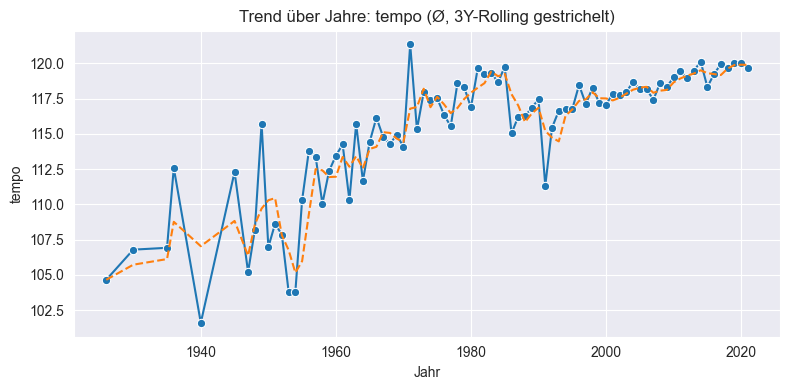

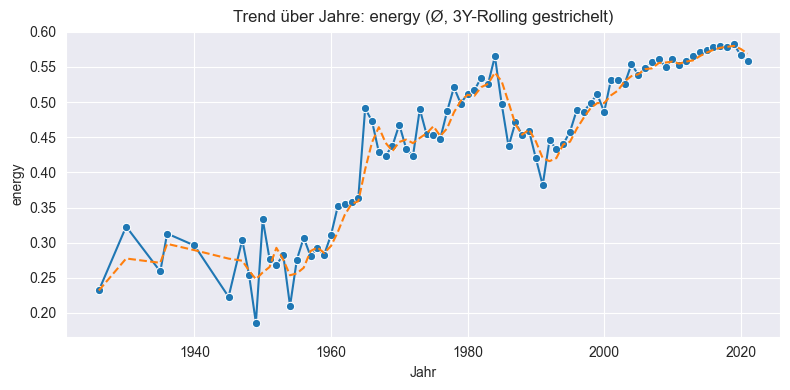

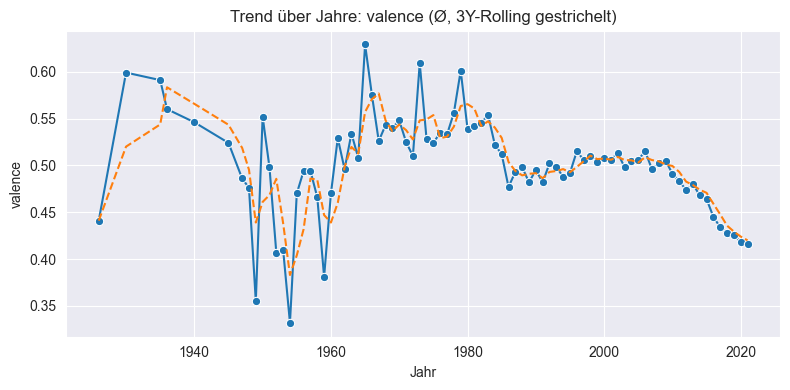

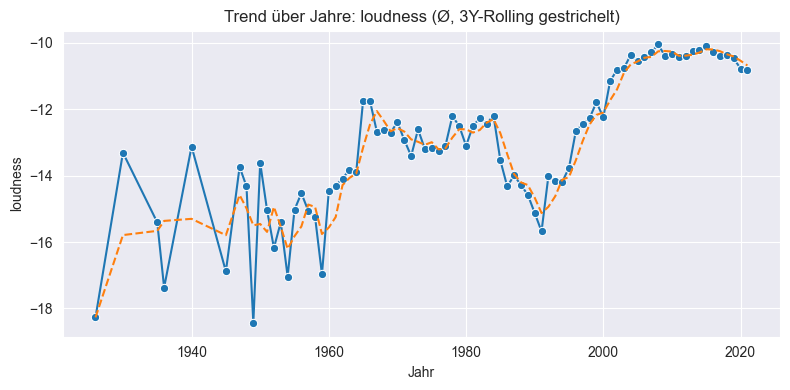

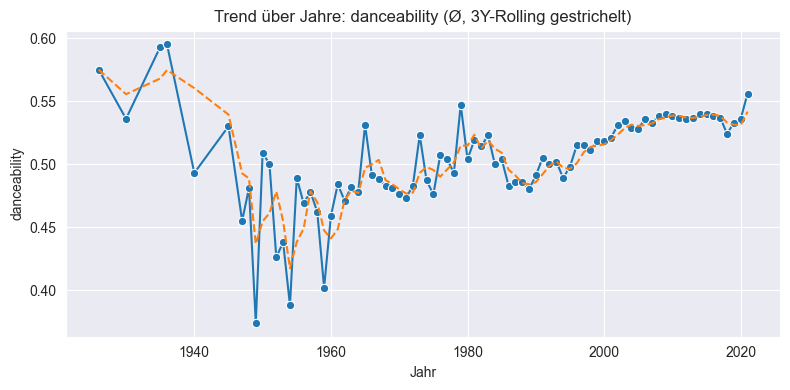

💾 Trend-Reports gespeichert unter: C:\GitHub\data-science\uni-course\spotify-data-project\data\reports\01_schema_overview\trends


In [30]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

TREND_DIR = Path("../data/reports/01_schema_overview/trends")
TREND_DIR.mkdir(parents=True, exist_ok=True)

# Load
tracks = pd.read_csv(DATA_DIR / "tracks.csv").rename(columns={"id": "track_id"})
audio  = pd.read_csv(DATA_DIR / "audio_features.csv").rename(columns={"id": "audio_feature_id"})
albums = pd.read_csv(DATA_DIR / "albums.csv")[["id", "release_date"]].rename(columns={"id": "album_id"})

# Optional relation (best way to map tracks -> albums)
rat_path = DATA_DIR / "r_albums_tracks.csv"
r_at = pd.read_csv(rat_path) if rat_path.exists() else None

# Base merge (tracks + audio)
df = tracks.merge(audio, on="audio_feature_id", how="left")

# Attach album_id properly
if r_at is not None:
    df = df.merge(r_at[["track_id", "album_id"]], on="track_id", how="left")
elif "album_id" in tracks.columns:
    df = df.merge(tracks[["track_id", "album_id"]], on="track_id", how="left")
else:
    df["album_id"] = pd.NA

# Join albums to get release_date
df = df.merge(albums, on="album_id", how="left")

# Parse release_date: it's ms timestamps (per your sample)
# (works whether dtype is str, int, or float)
s = pd.to_numeric(df["release_date"], errors="coerce")
df["release_dt"] = pd.to_datetime(s, unit="ms", errors="coerce")
df["year"] = df["release_dt"].dt.year

# Features & yearly aggregation
feat_cols = [c for c in ["tempo", "energy", "valence", "loudness", "danceability"] if c in df.columns]
yearly = (
    df.dropna(subset=["year"])
      .groupby("year")[feat_cols]
      .mean()
      .round(3)
)

# Add counts to judge stability; optionally filter sparse years
yearly["count"] = df.groupby("year")["track_id"].count()
MIN_YEAR_COUNT = 50
yearly_filtered = yearly[yearly["count"] >= MIN_YEAR_COUNT]

# Save table
yearly_filtered.to_csv(TREND_DIR / "yearly_trends.csv", encoding="utf-8", index=True)

# Plots: per-feature trend + 3Y rolling mean (dashed)
for c in feat_cols:
    s = yearly_filtered[c].dropna()
    plt.figure(figsize=(8, 4))
    sns.lineplot(x=s.index, y=s.values, marker="o")
    if len(s) >= 3:
        s_roll = s.rolling(3, min_periods=1).mean()
        sns.lineplot(x=s_roll.index, y=s_roll.values, linestyle="--")
    plt.title(f"Trend über Jahre: {c} (Ø, 3Y-Rolling gestrichelt)")
    plt.xlabel("Jahr"); plt.ylabel(c)
    plt.tight_layout()
    plt.savefig(TREND_DIR / f"trend_{c}.png", dpi=150)
    plt.show()

print(f" Trend-Reports gespeichert unter: {TREND_DIR.resolve()}")



## 1.10 Cross-Table Relationship: Artist Influence

**Ziel**
Ich untersuche, ob **Künstler-Reichweite** (Followers) mit **Erfolg ihrer Songs** (Ø-Track-Popularität) zusammenhängt.

**Ergebnis**
- Scatter + Regressionslinie (log-Followers)
- `artist_influence.csv`


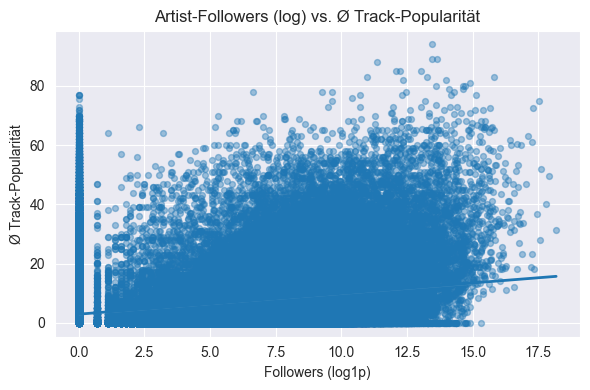

 Artist-Influence gespeichert unter: C:\GitHub\data-science\uni-course\spotify-data-project\data\reports\01_schema_overview\influence
Columns used: {'tracks': ['track_id', 'track_popularity'], 'artists': ['artist_id', 'followers', 'artist_popularity'], 'r_track_artist': ['track_id', 'artist_id']}


In [32]:
INF_DIR = Path("../data/reports/01_schema_overview/influence")
INF_DIR.mkdir(parents=True, exist_ok=True)

# --- Helpers to resolve column names across schema variants
def pick(dframe, candidates, required=True):
    for c in candidates:
        if c in dframe.columns:
            return c
    if required:
        raise KeyError(f"None of {candidates} found in columns: {list(dframe.columns)}")
    return None

# --- Load CSVs
tracks = pd.read_csv(DATA_DIR / "tracks.csv", encoding="utf-8")  # ensure headers load
artists = pd.read_csv(DATA_DIR / "artists.csv", encoding="utf-8")
rta = pd.read_csv(DATA_DIR / "r_track_artist.csv", encoding="utf-8")

# --- Resolve column names
track_id_col = pick(tracks, ["track_id", "id"])
track_pop_col = pick(tracks, ["popularity"])

artist_id_col = pick(artists, ["artist_id", "id"])
followers_col  = pick(artists, ["followers", "followers_count"])
artist_pop_col = pick(artists, ["artist_popularity", "popularity"], required=False)  # optional

rta_track_col  = pick(rta, ["track_id", "trackId", "trackID"])
rta_artist_col = pick(rta, ["artist_id", "artistId", "artistID"])

# --- Minimal frames with normalized names
tracks_min = tracks[[track_id_col, track_pop_col]].rename(
    columns={track_id_col: "track_id", track_pop_col: "track_popularity"}
)

artists_min_cols = [artist_id_col, followers_col]
rename_map = {artist_id_col: "artist_id", followers_col: "followers"}
if artist_pop_col:
    artists_min_cols.append(artist_pop_col)
    rename_map[artist_pop_col] = "artist_popularity"

artists_min = artists[artists_min_cols].rename(columns=rename_map)

rta_min = rta[[rta_track_col, rta_artist_col]].rename(
    columns={rta_track_col: "track_id", rta_artist_col: "artist_id"}
)

# --- Avg track popularity per artist
track_pop_by_artist = (
    rta_min.merge(tracks_min, on="track_id", how="left")
           .groupby("artist_id", as_index=False)["track_popularity"]
           .mean()
           .rename(columns={"track_popularity": "avg_track_popularity"})
)

# --- Combine with artist followers (and optional artist_popularity)
df = artists_min.merge(track_pop_by_artist, on="artist_id", how="left")
df = df.dropna(subset=["avg_track_popularity"])

# Followers cleaning: ensure non-negative numbers
df["followers"] = pd.to_numeric(df["followers"], errors="coerce").fillna(0).clip(lower=0)

# Log-transform followers (log1p handles zeros)
df["followers_log1p"] = np.log1p(df["followers"])

# --- Plot: Scatter + regression line
plt.figure(figsize=(6, 4))
sns.regplot(
    data=df,
    x="followers_log1p",
    y="avg_track_popularity",
    scatter_kws={"alpha": 0.4, "s": 18},
    line_kws={"linewidth": 2}
)
plt.title("Artist-Followers (log) vs. Ø Track-Popularität")
plt.xlabel("Followers (log1p)")
plt.ylabel("Ø Track-Popularität")
plt.tight_layout()
plt.savefig(INF_DIR / "artist_followers_vs_avg_track_popularity.png", dpi=150)
plt.show()

# --- Save CSV
cols_out = ["artist_id", "followers", "avg_track_popularity", "followers_log1p"]
if "artist_popularity" in df.columns:
    cols_out.insert(2, "artist_popularity")

df[cols_out].to_csv(INF_DIR / "artist_influence.csv", index=False, encoding="utf-8-sig")

print(f" Artist-Influence gespeichert unter: {INF_DIR.resolve()}")
print("Columns used:",
      {"tracks": list(tracks_min.columns),
       "artists": list(artists_min.columns),
       "r_track_artist": list(rta_min.columns)})

